Description

The dataset contains extracted attributes from websites that can be used for Classification of webpages as malicious or benign. 
The dataset also includes raw page content including JavaScript code that can be used as unstructured data in Deep Learning or for extracting further attributes. The data has been collected by crawling the Internet using MalCrawler [1]. The labels have been verified using the Google Safe Browsing API [2]. Attributes have been selected based on their relevance [3]. The details of dataset attributes is as given below: 

'url'             - The URL of the webpage. <br />
'ip_add'          - IP Address of the webpage. <br />
'geo_loc'         - The geographic location where the webpage is hosted. <br />
'url_len'         - The length of URL. <br />
'js_len'          - Length of JavaScript code on the webpage. <br />
'js_obf_len'      - Length of obfuscated JavaScript code. <br />
'tld'             - The Top Level Domain of the webpage. <br />
'who_is'          - Whether the WHO IS domain information is compete or not. <br />
'https'           - Whether the site uses https or http. <br />
'content'         - The raw webpage content including JavaScript code. <br />
'label'           - The class label for benign or malicious webpage. <br />

# Import Modules and Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


# Import ML library and its modules
import sklearn
import xgboost as xgb

## Import train_test_split, cross_val_score, KFold - Validation and GridSearchCV  
from sklearn.model_selection import  train_test_split, cross_val_score, GridSearchCV, KFold 

# Import Classifiers - Modelling
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
 

# Import Metrics - Performance Evaluation
from sklearn import metrics

In [2]:
import warnings
warnings.filterwarnings("ignore")


In [3]:
pd.set_option('display.max_columns', None)

%matplotlib inline

# Load Train and Test data from sampled files

In [4]:
train = pd.read_csv("sampled_webpages_classification_train_data.csv")

## Understand the Dataset and Data

### Understand Train Data

In [5]:
train.shape

(12000, 11)

In [6]:
train.columns

Index(['url', 'url_len', 'ip_add', 'geo_loc', 'tld', 'who_is', 'https',
       'js_len', 'js_obf_len', 'content', 'label'],
      dtype='object')

In [7]:
train.label.value_counts()/train.shape[0]

good    0.97675
bad     0.02325
Name: label, dtype: float64

In [8]:
train.head()

url  url_len          ip_add  \
0  http://www.bibliomania.com/0/0/29/61/frameset....       50  185.233.21.226   
1  http://scitec.uwichill.edu.bb/bcs/staff/lec/fe...       86   39.168.85.148   
2  http://www.na.fs.fed.us/spfo/pubs/silvics_manu...       79    31.134.59.34   
3           http://home.comcast.net/~augusta-aikido/       40   215.139.38.85   
4                              http://www.nbcal.com/       21   31.98.226.124   

          geo_loc     tld      who_is https  js_len  js_obf_len  \
0         Czechia     com    complete   yes   137.0         0.0   
1           China  edu.bb    complete    no   124.5         0.0   
2          Poland  fed.us  incomplete    no    86.5         0.0   
3   United States     net    complete   yes    32.0         0.0   
4  United Kingdom     com    complete   yes   133.0         0.0   

                                             content label  
0  Anti-jewish policies excluding bornholm. the d...  good  
1  Four seasons as politics: how psychological ex...  good  
2  brea5t ontherag jigaboo jizzum stringer slime ...  good  
3  Other predictions division of the regions are....  good  
4  Suez crisis. dillon, montana moonlight basin n...  good

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   url         12000 non-null  object 
 1   url_len     12000 non-null  int64  
 2   ip_add      12000 non-null  object 
 3   geo_loc     12000 non-null  object 
 4   tld         12000 non-null  object 
 5   who_is      12000 non-null  object 
 6   https       12000 non-null  object 
 7   js_len      12000 non-null  float64
 8   js_obf_len  12000 non-null  float64
 9   content     12000 non-null  object 
 10  label       12000 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 1.0+ MB


In [10]:
train.dtypes.value_counts()

object     8
float64    2
int64      1
dtype: int64

# Clean the Data

### Convert label values from bad and good to 1 and 0 respectively

In [11]:
train['label']=np.where(train['label']=='bad', 1, 0) # bad=1 and good=0
train['label'].head()

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int32

### Duplicate Values

In [12]:
train.duplicated().sum()

0

*No duplication of rows in the dataset*

## Numerical Features

In [13]:
num_cols = (train.select_dtypes(exclude="object").columns.values).tolist()
num_cols

['url_len', 'js_len', 'js_obf_len', 'label']

### Null values

*Find NaN values in the numerical columns in the dataset to clean them*

In [14]:
train[num_cols].isna().sum()

url_len       0
js_len        0
js_obf_len    0
label         0
dtype: int64

*No NaN values in the numerical columns in the dataset to clean*

### Zeros Values

*Find unexpected zero valued rows in the numerical columns in the dataset*

In [15]:
train.loc[(train[num_cols]==0).all(axis=1),num_cols].sum()/train[num_cols].shape[0] # Percentage of rows having 0 values

url_len       0.0
js_len        0.0
js_obf_len    0.0
label         0.0
dtype: float64

*There are no rows which have all row values == 0*

### Nonsensical values

*Find any non-numeric values in numerical columns*

In [16]:
train[num_cols].apply(lambda x: str(x).isnumeric()).sum()

0

*There are no non-numeric values in the numerical columns in the dataset*

## Categorical Features

In [17]:
cat_cols = train.select_dtypes(include="object").columns.values.tolist()
cat_cols

['url', 'ip_add', 'geo_loc', 'tld', 'who_is', 'https', 'content']

### Null

*Find NaN values in the categorical columns in the dataset to clean them*

In [18]:
train[cat_cols].isna().sum()

url        0
ip_add     0
geo_loc    0
tld        0
who_is     0
https      0
content    0
dtype: int64

*No NaN values in the categorical columns in the dataset to clean*

### Empty Strings

*Find empty strings in the categorical columns in the dataset*

In [19]:
train[train[cat_cols].values == ''].sum()

url           0.0
url_len       0.0
ip_add        0.0
geo_loc       0.0
tld           0.0
who_is        0.0
https         0.0
js_len        0.0
js_obf_len    0.0
content       0.0
label         0.0
dtype: float64

*No empty values in the categorical columns in the dataset*

# Exploratory Data Analysis

## Numerical Columns

In [20]:
num_cols

['url_len', 'js_len', 'js_obf_len', 'label']

### Univariate

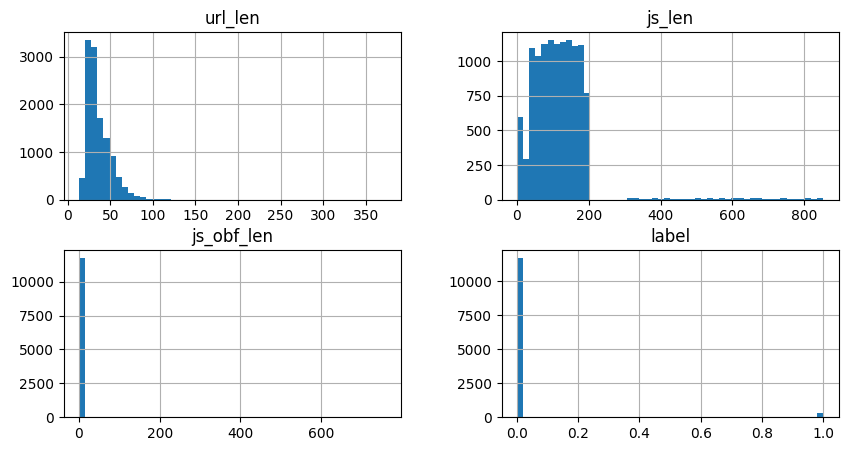

In [21]:
train[num_cols].hist(bins=50, figsize=(10,5), layout=(2,2))
plt.show()

**Observations:**
- url_len: The lengths of the majority of the urls are below 50
- js_len: The length of javascript(js) code of majority of the webages are <= 200.
- js_obf_len: The length of obfuscated js code of majority of the website are very close to 0
- label: The majority of the labels are 0(good). The indicates a imbalanced dataset.

**The above observations can also be ascertained by using train.describe()**

In [22]:
train.describe()

url_len        js_len    js_obf_len         label
count  12000.000000  12000.000000  12000.000000  12000.000000
mean      36.111833    119.927408      8.228616      0.023250
std       14.971056     91.054894     60.120327      0.150703
min       13.000000      0.000000      0.000000      0.000000
25%       26.000000     67.500000      0.000000      0.000000
50%       32.000000    113.000000      0.000000      0.000000
75%       43.000000    158.000000      0.000000      0.000000
max      373.000000    853.200000    758.547000      1.000000

### Bivariate

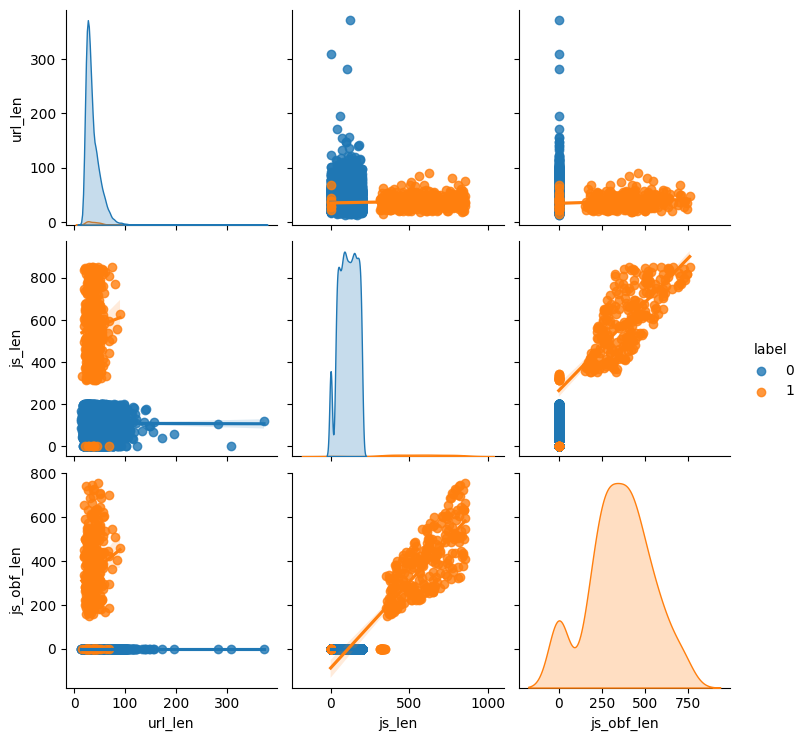

In [23]:
# Pairplot
sns.pairplot(train[num_cols],kind ='reg',diag_kind='kde', hue='label')
plt.show()

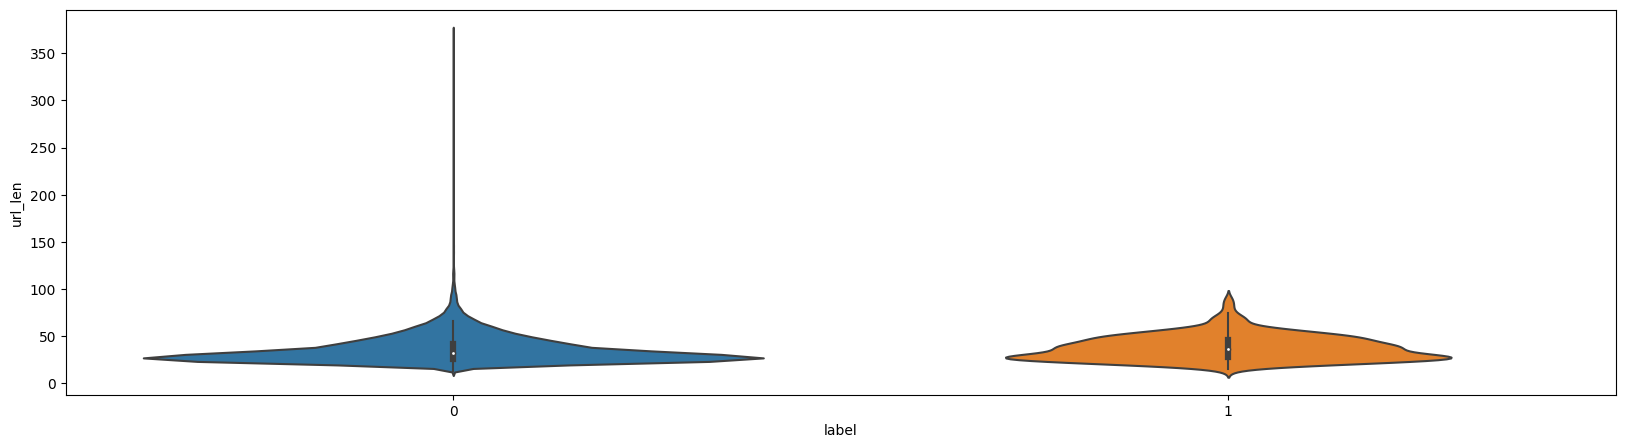

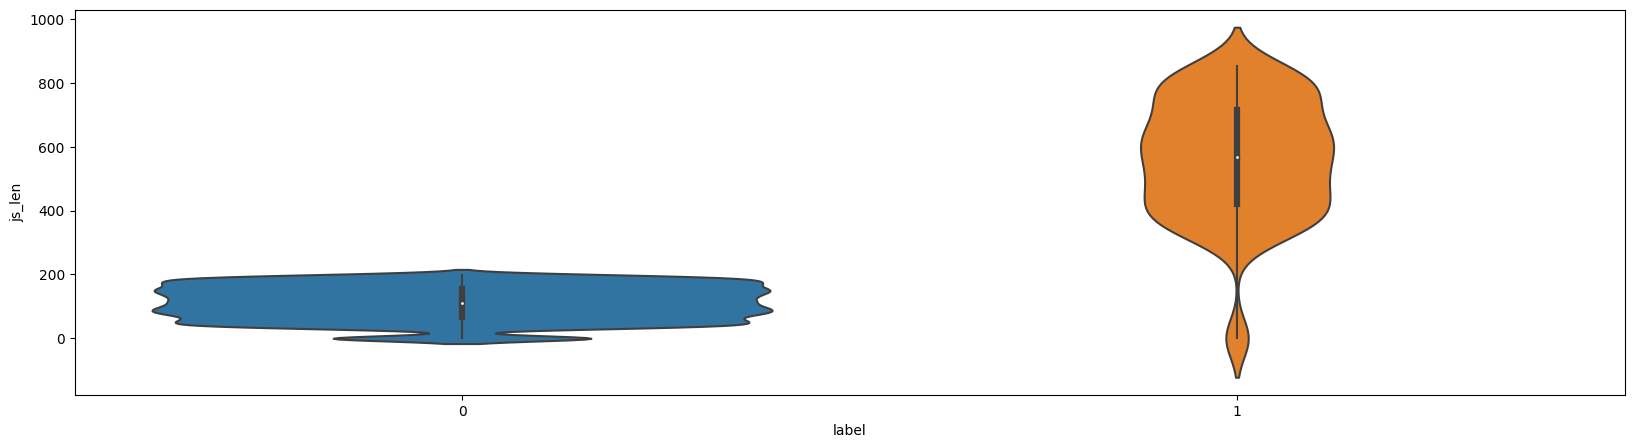

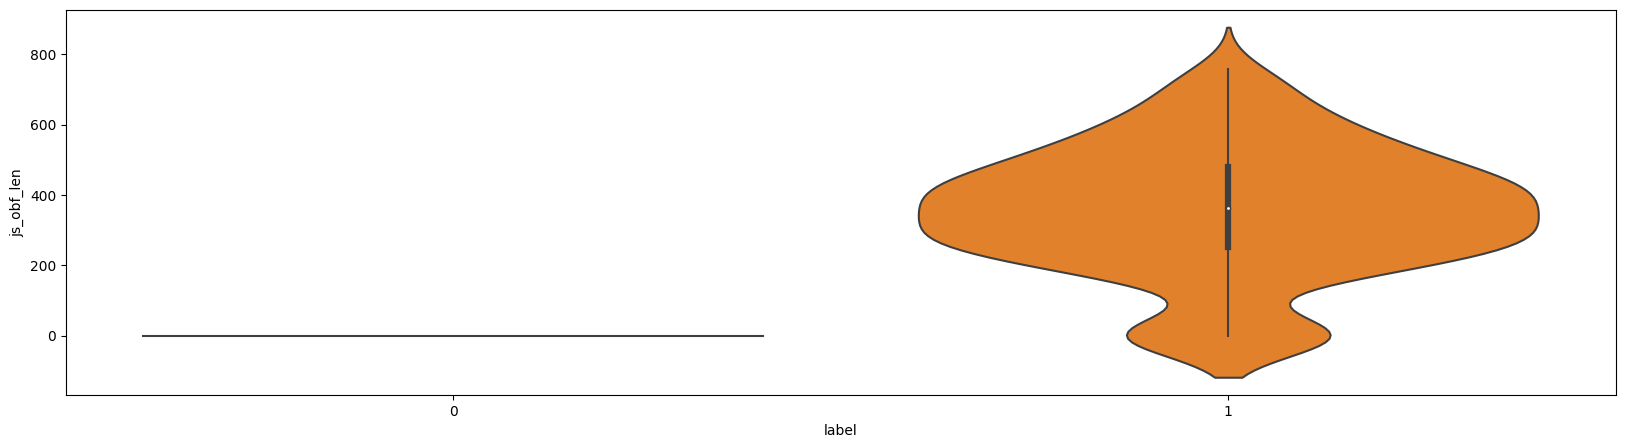

In [24]:
# Violin Plot
for i, col in enumerate(num_cols):
    if (col!='label'):
        plt.figure(i,figsize = (20,5))
        sns.violinplot(x='label',y=col, data=train)
    else:
        break

In [25]:
 train[train["label"]==0]["js_len"].min(), train[train["label"]==0]["js_len"].max()

(0.0, 199.5)

In [26]:
 train[train["label"]==1]["js_len"].min(), train[train["label"]==1]["js_len"].max()

(0.0, 853.2)

In [27]:
 train[train["label"]==0]["js_obf_len"].min(), train[train["label"]==0]["js_obf_len"].max()

(0.0, 0.0)

In [28]:
 train[train["label"]==1]["js_obf_len"].min(), train[train["label"]==1]["js_obf_len"].max()

(0.0, 758.547)

**Observations**
- **url_len vs label**:  url_length doesn't seem to indicate any strong relationship with label column <br>
- **js_len vs label**:  js_len seems to have a strong relationship with label column  
    - **Label==0**: Smaller js_len (i.e. js_len<=200) seems to be strongly connected to label=0(good) websites 
    - **Label==1**: Majority of larger js_len (i.e. js_len> 200) seems to be strongly connected to label=1(bad) websites<br>
    
- **js_obf_len vs label**: The length of obfuscated js code is 0 for good websites and varies from 0 to 758.547 for bad websites<br>

 

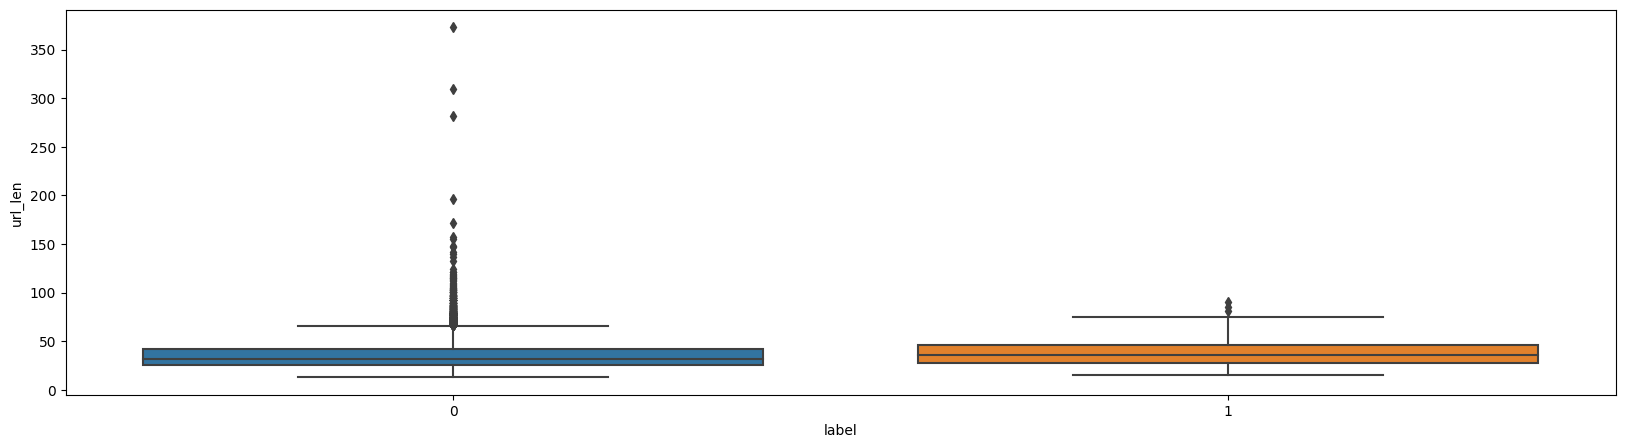

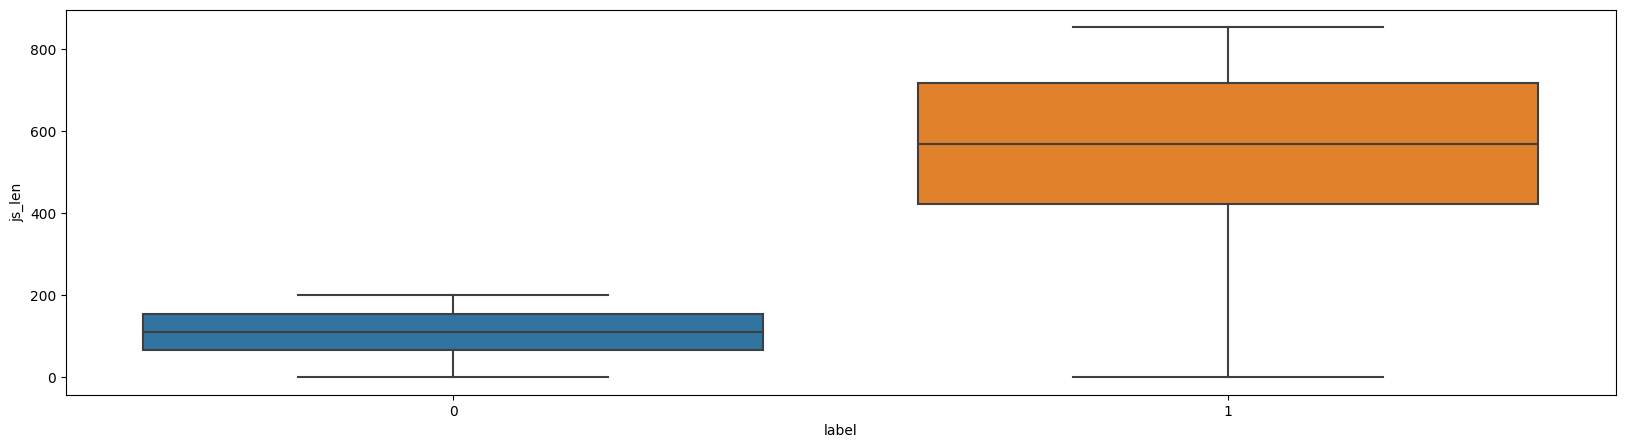

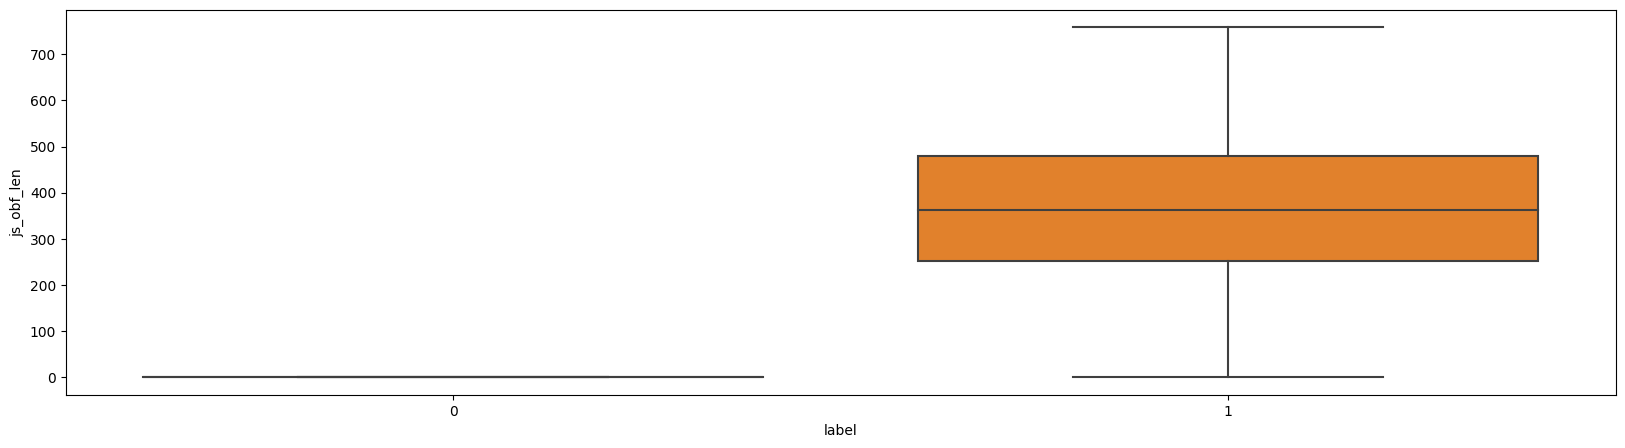

In [29]:
# Box Plot to understand the distribution of values numerical columns wrt labels
for i, col in enumerate(num_cols):
    if (col!='label'):
        plt.figure(i,figsize = (20,5))
        sns.boxplot(x='label',y=col, data=train)
    else:
        break

**Observations**
- Confirms our observations wrt violin plot. <br>
- **js_len vs label**: <br>
    - **Label=0**: Shows that all of js_len is distributed between 0 and 200 for good websites  <br>
    - **Label=1**: Shows that majority of js_len is distributed between 400 and 750 for bad websites<br>
- **js_obf_len vs label**:
    - **Label=0**: Shows that all of  js_obf_len are 0 for good websites <br>
    - **Label=1**: Shows that majority of js_obf_len is distributed between 250 and 500 for bad websites<br>

***The above observations indicate that js_len and js_obs can be good candidates as predictors for label amongst numerical columns***

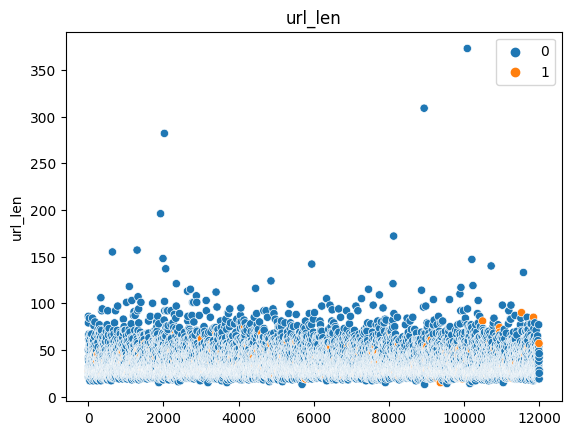

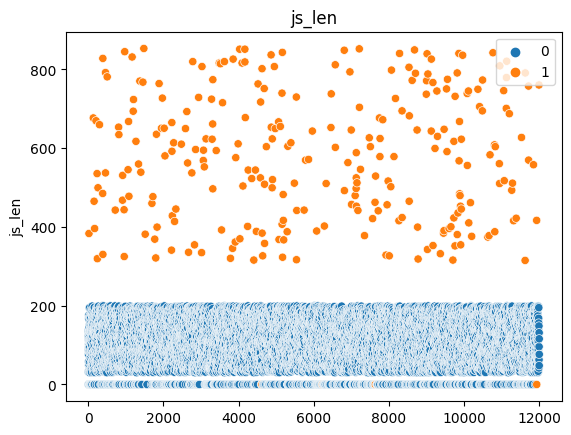

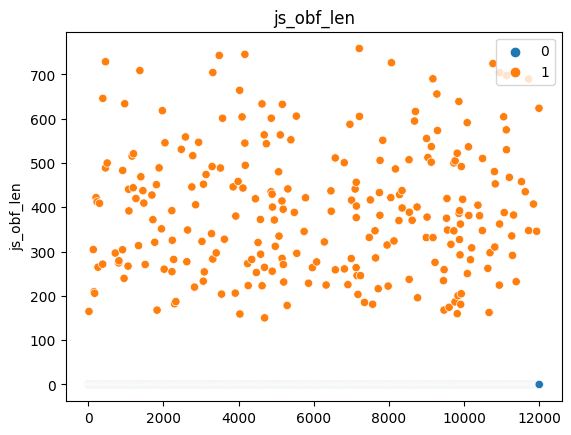

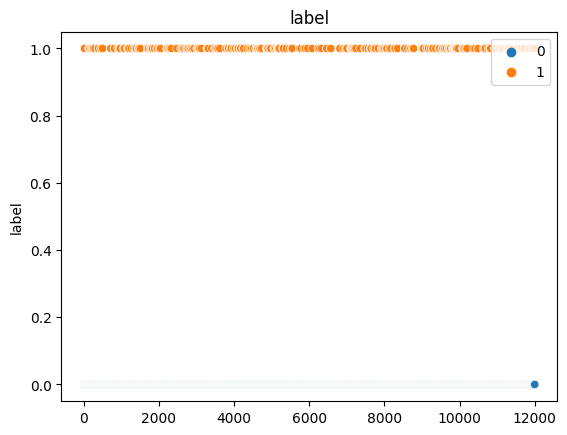

In [30]:
# Scatterplot to visualize how the numerical data for each column is scattered wrt label
for col in num_cols:
    plt.title(col)
    sns.scatterplot(x=train.index.values,y=train[col], data=train, hue="label")
    plt.legend(loc="upper right")
    plt.show()

***Confirms our above observations***

<Figure size 2000x500 with 0 Axes>

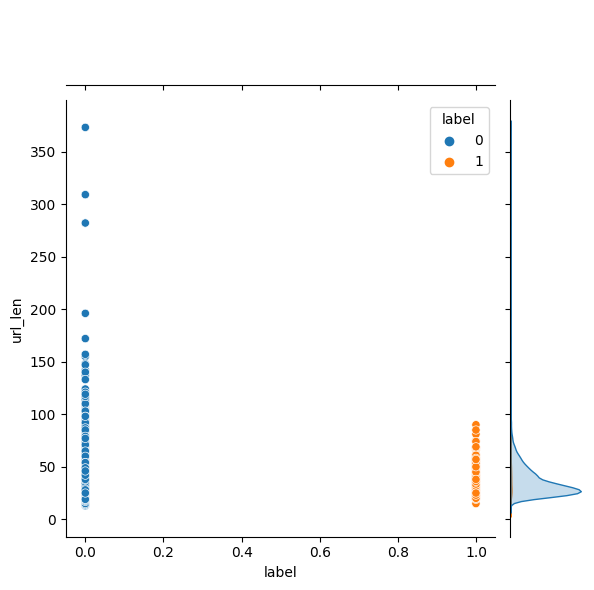

<Figure size 2000x500 with 0 Axes>

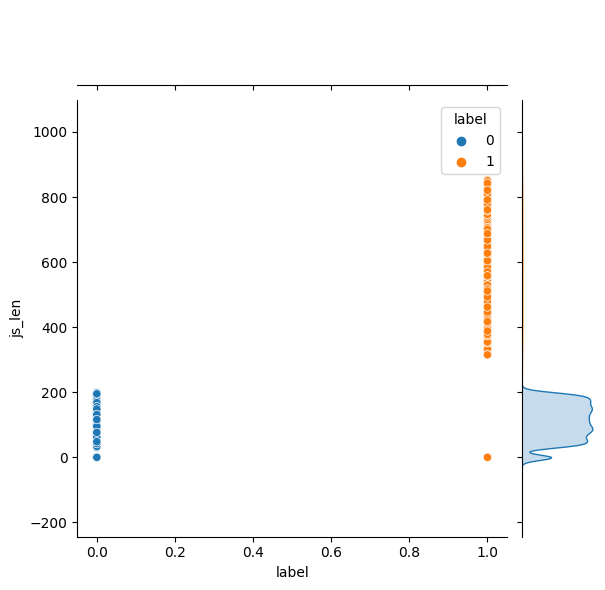

<Figure size 2000x500 with 0 Axes>

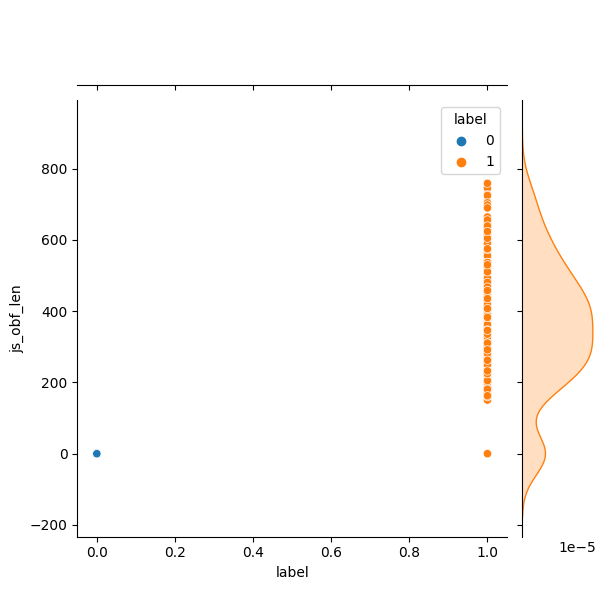

In [31]:
# Jointplot to visualize how the data is distributed wrt to labels 
for i, col in enumerate(num_cols):
    if (col!='label'):
        plt.figure(i,figsize = (20,5))
        sns.jointplot(x='label', y=col, data=train, hue='label')
        plt.show()
    else:
        break

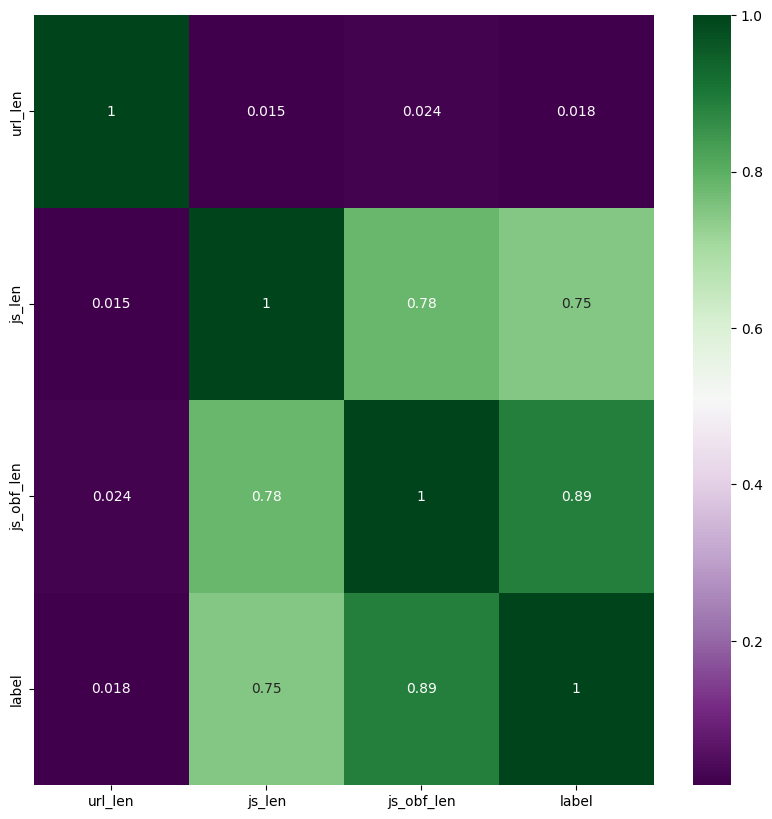

In [32]:
# Heatmap to understand the correlations between numerical columns and label
plt.figure(figsize=(10,10))
sns.heatmap(train.corr(), annot = True,cmap= "PRGn")
plt.show()

***The correlation heatmap also confirms that js_len and js_obf_len are quite strongly correlated with labels***

### Categorical Columns

In [33]:
cat_cols

['url', 'ip_add', 'geo_loc', 'tld', 'who_is', 'https', 'content']

***Since url, ip and content features are generally unique, we can remove then from graphical analysis***

### Univariate

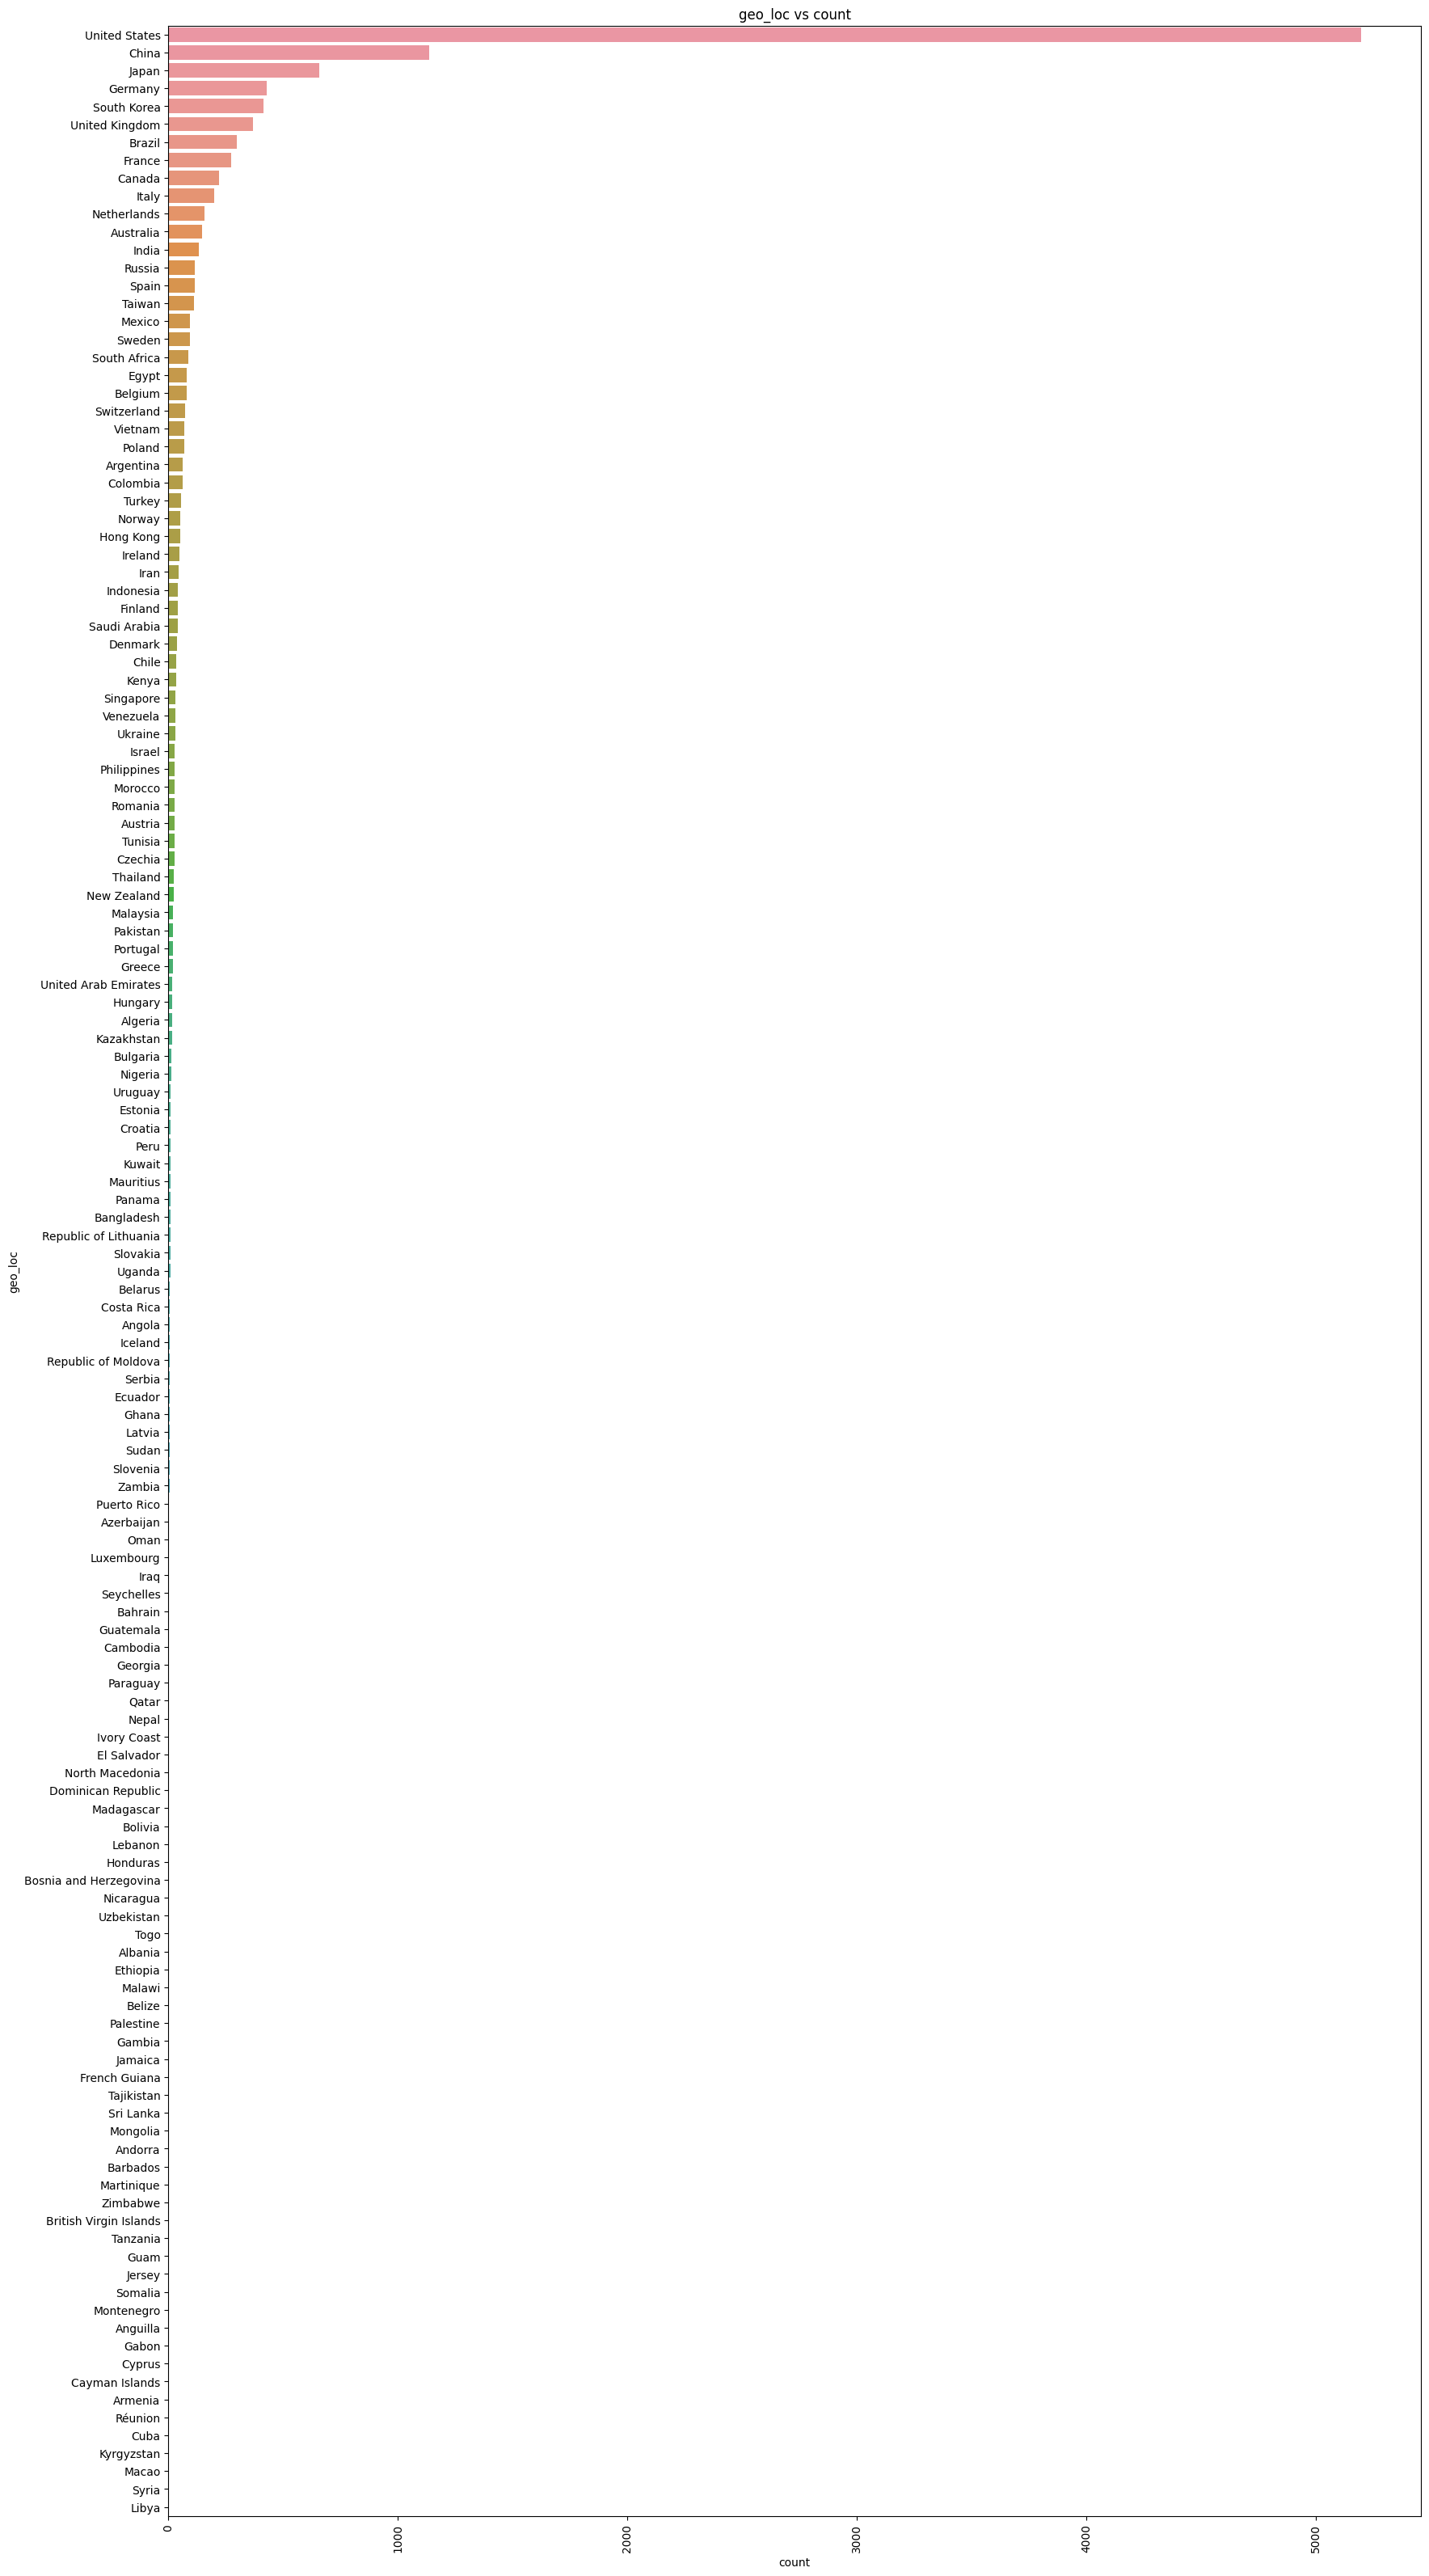

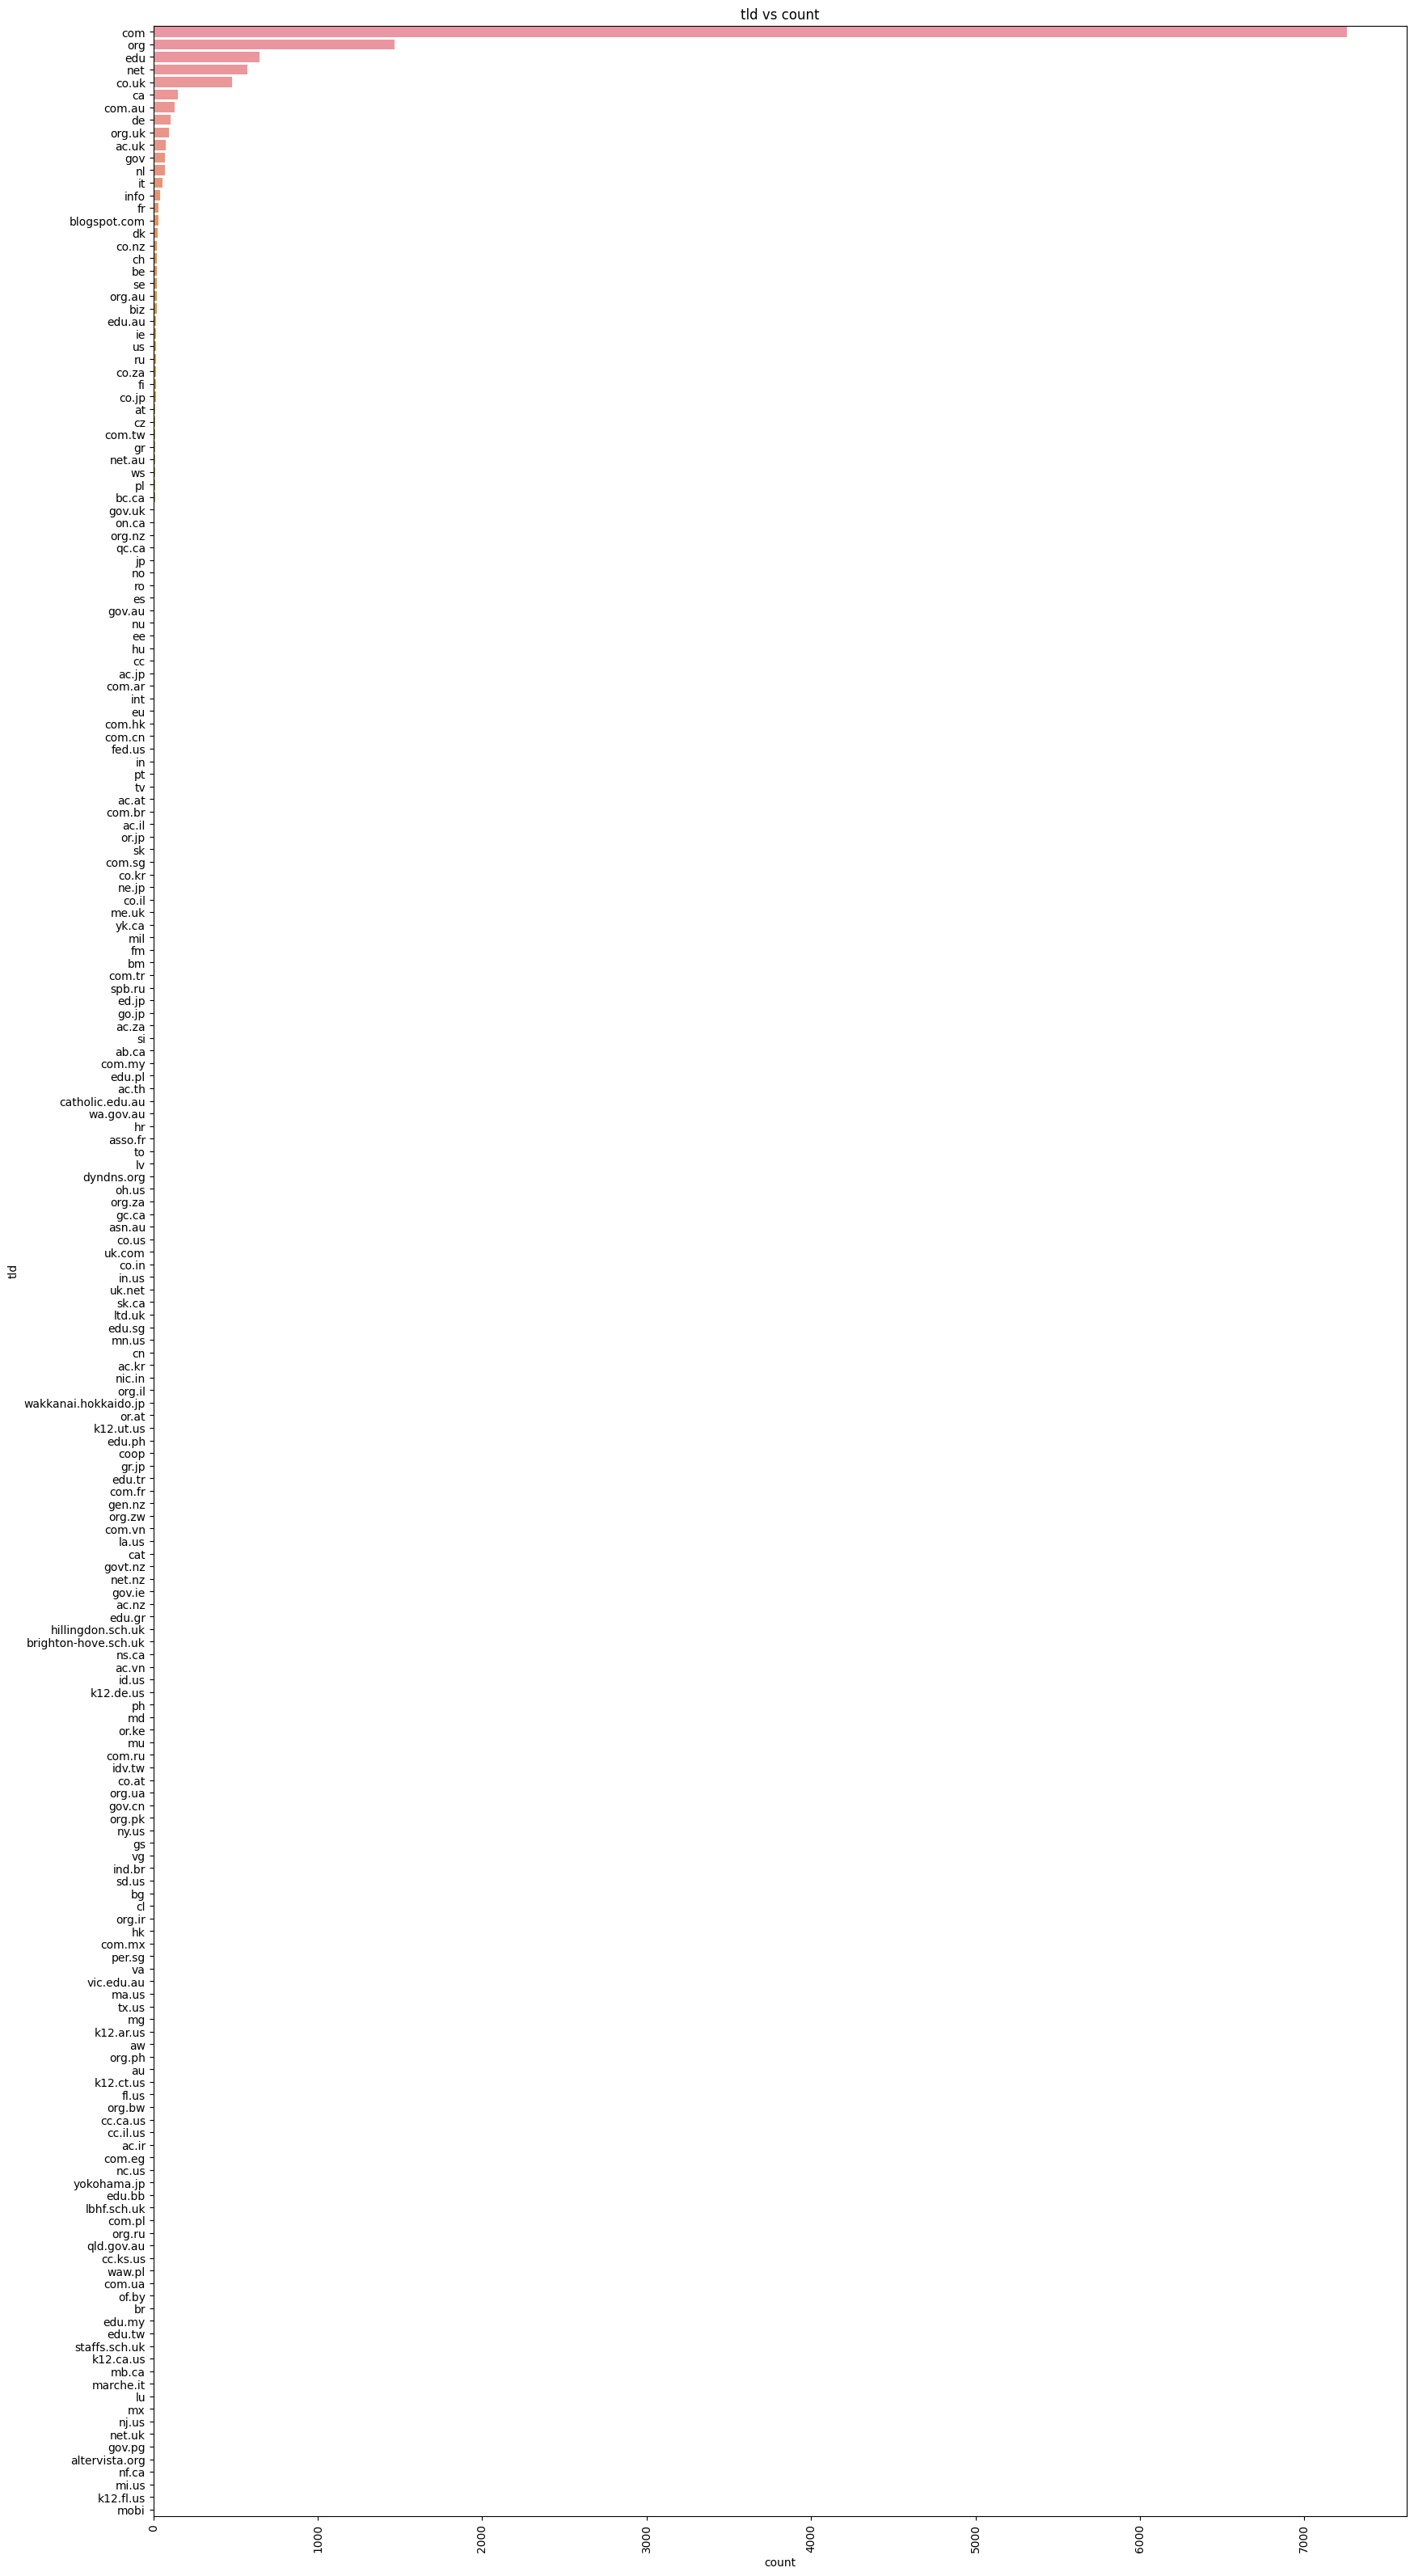

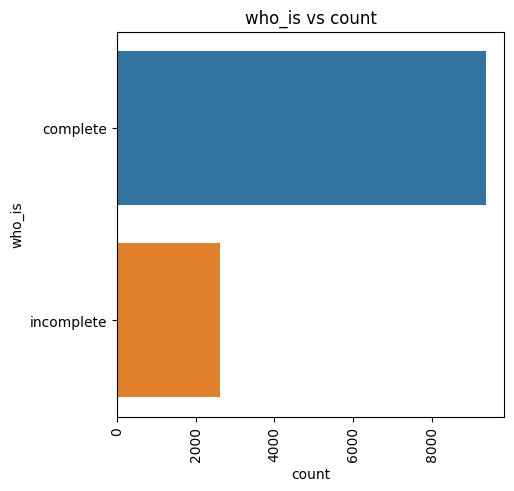

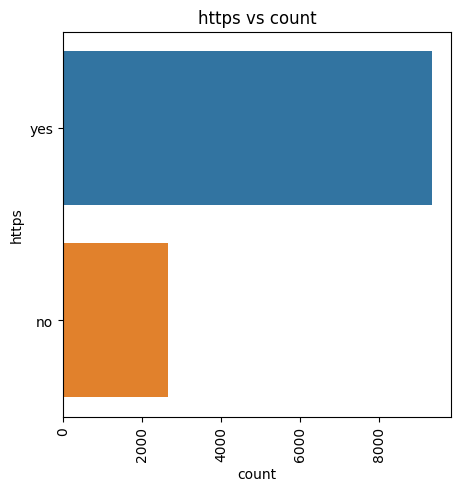

In [34]:
for i, col in enumerate(cat_cols):
    if(col not in ['url','ip_add','content']):
        if (col == 'geo_loc'):
            plt.figure(i, figsize = (20,40))
            plt.title(f"{col} vs count")
            sns.countplot(y=col, data=train, order=train[col].value_counts().index)
            plt.xticks(rotation=90)
            plt.show()
        
        else:
            if(col == 'tld'):
                plt.figure(i,figsize = (20,40))
                plt.title(f"{col} vs count")
                sns.countplot(y=col, data=train, order=train[col].value_counts().index)
                plt.xticks(rotation=90)
                plt.show()
            
            else:   
                plt.figure(i,figsize = (5,5))
                plt.title(f"{col} vs count")
                sns.countplot(y=col, data=train)
                plt.xticks(rotation=90)
                plt.show()
    else:
        pass


In [35]:
(train['geo_loc'].value_counts().nlargest(10)/train['geo_loc'].shape[0])*100

United States     43.316667
China              9.466667
Japan              5.483333
Germany            3.566667
South Korea        3.466667
United Kingdom     3.075000
Brazil             2.483333
France             2.291667
Canada             1.841667
Italy              1.650000
Name: geo_loc, dtype: float64

In [36]:
train['geo_loc'].value_counts().nlargest(30).sum()/train['geo_loc'].shape[0]

0.9129166666666667

In [37]:
(train['tld'].value_counts().nlargest(10)/train['tld'].shape[0])*100

com       60.483333
org       12.233333
edu        5.400000
net        4.775000
co.uk      3.991667
ca         1.225000
com.au     1.083333
de         0.883333
org.uk     0.800000
ac.uk      0.625000
Name: tld, dtype: float64

In [38]:
(train["who_is"].value_counts()/train['who_is'].shape[0])*100

complete      78.116667
incomplete    21.883333
Name: who_is, dtype: float64

In [39]:
(train["https"].value_counts()/train['https'].shape[0])*100

yes    77.841667
no     22.158333
Name: https, dtype: float64

**Observations**
- **geo_loc**: Webpages belonging to 30 countries account for 91.29% of data
    - 43.3% of the webpages are from United States, 9.4% from China, 5.4% from Japan and so on.
- **tld**: .com, .org, .edu, .net top level domains account for 82.89% of webpages considered
- **who_is**: 78.11% of webpages had their who_is complete information while 21.88% webpages' who_is information was incomplete
- **https**: 77.84% of webpages considered in the dataset use https while 22.15% don't use it

### Bivariate

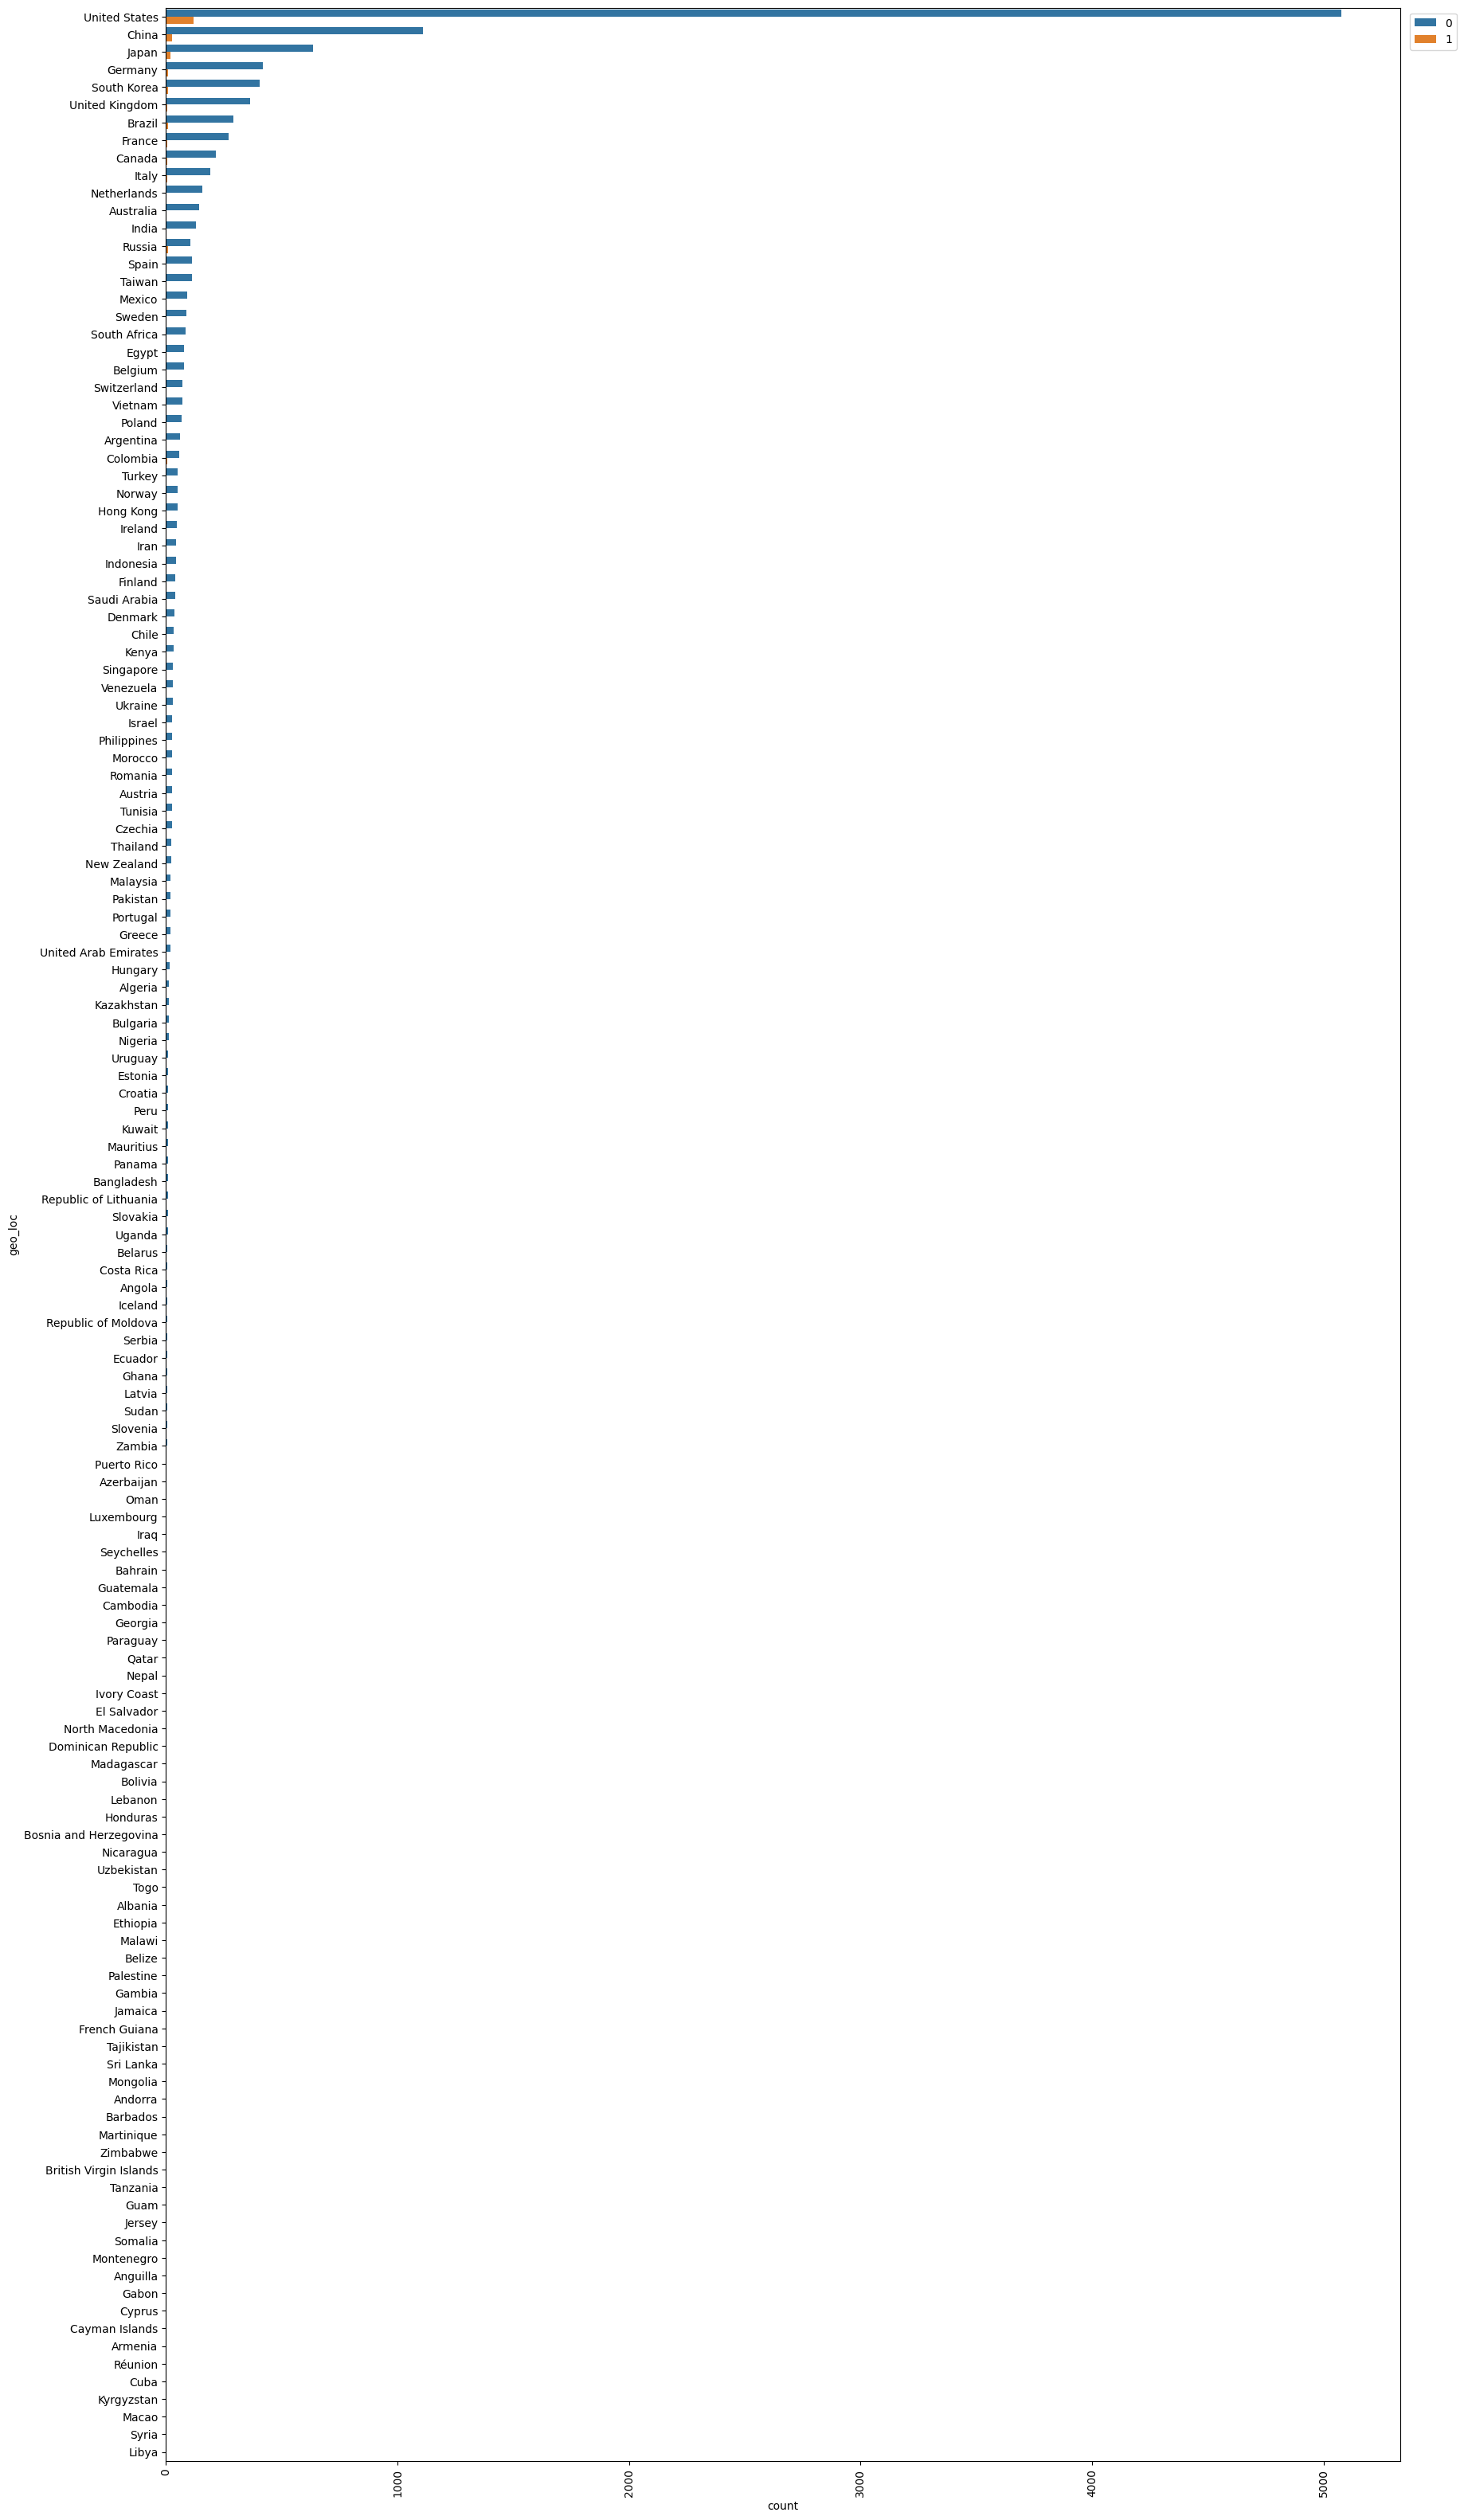

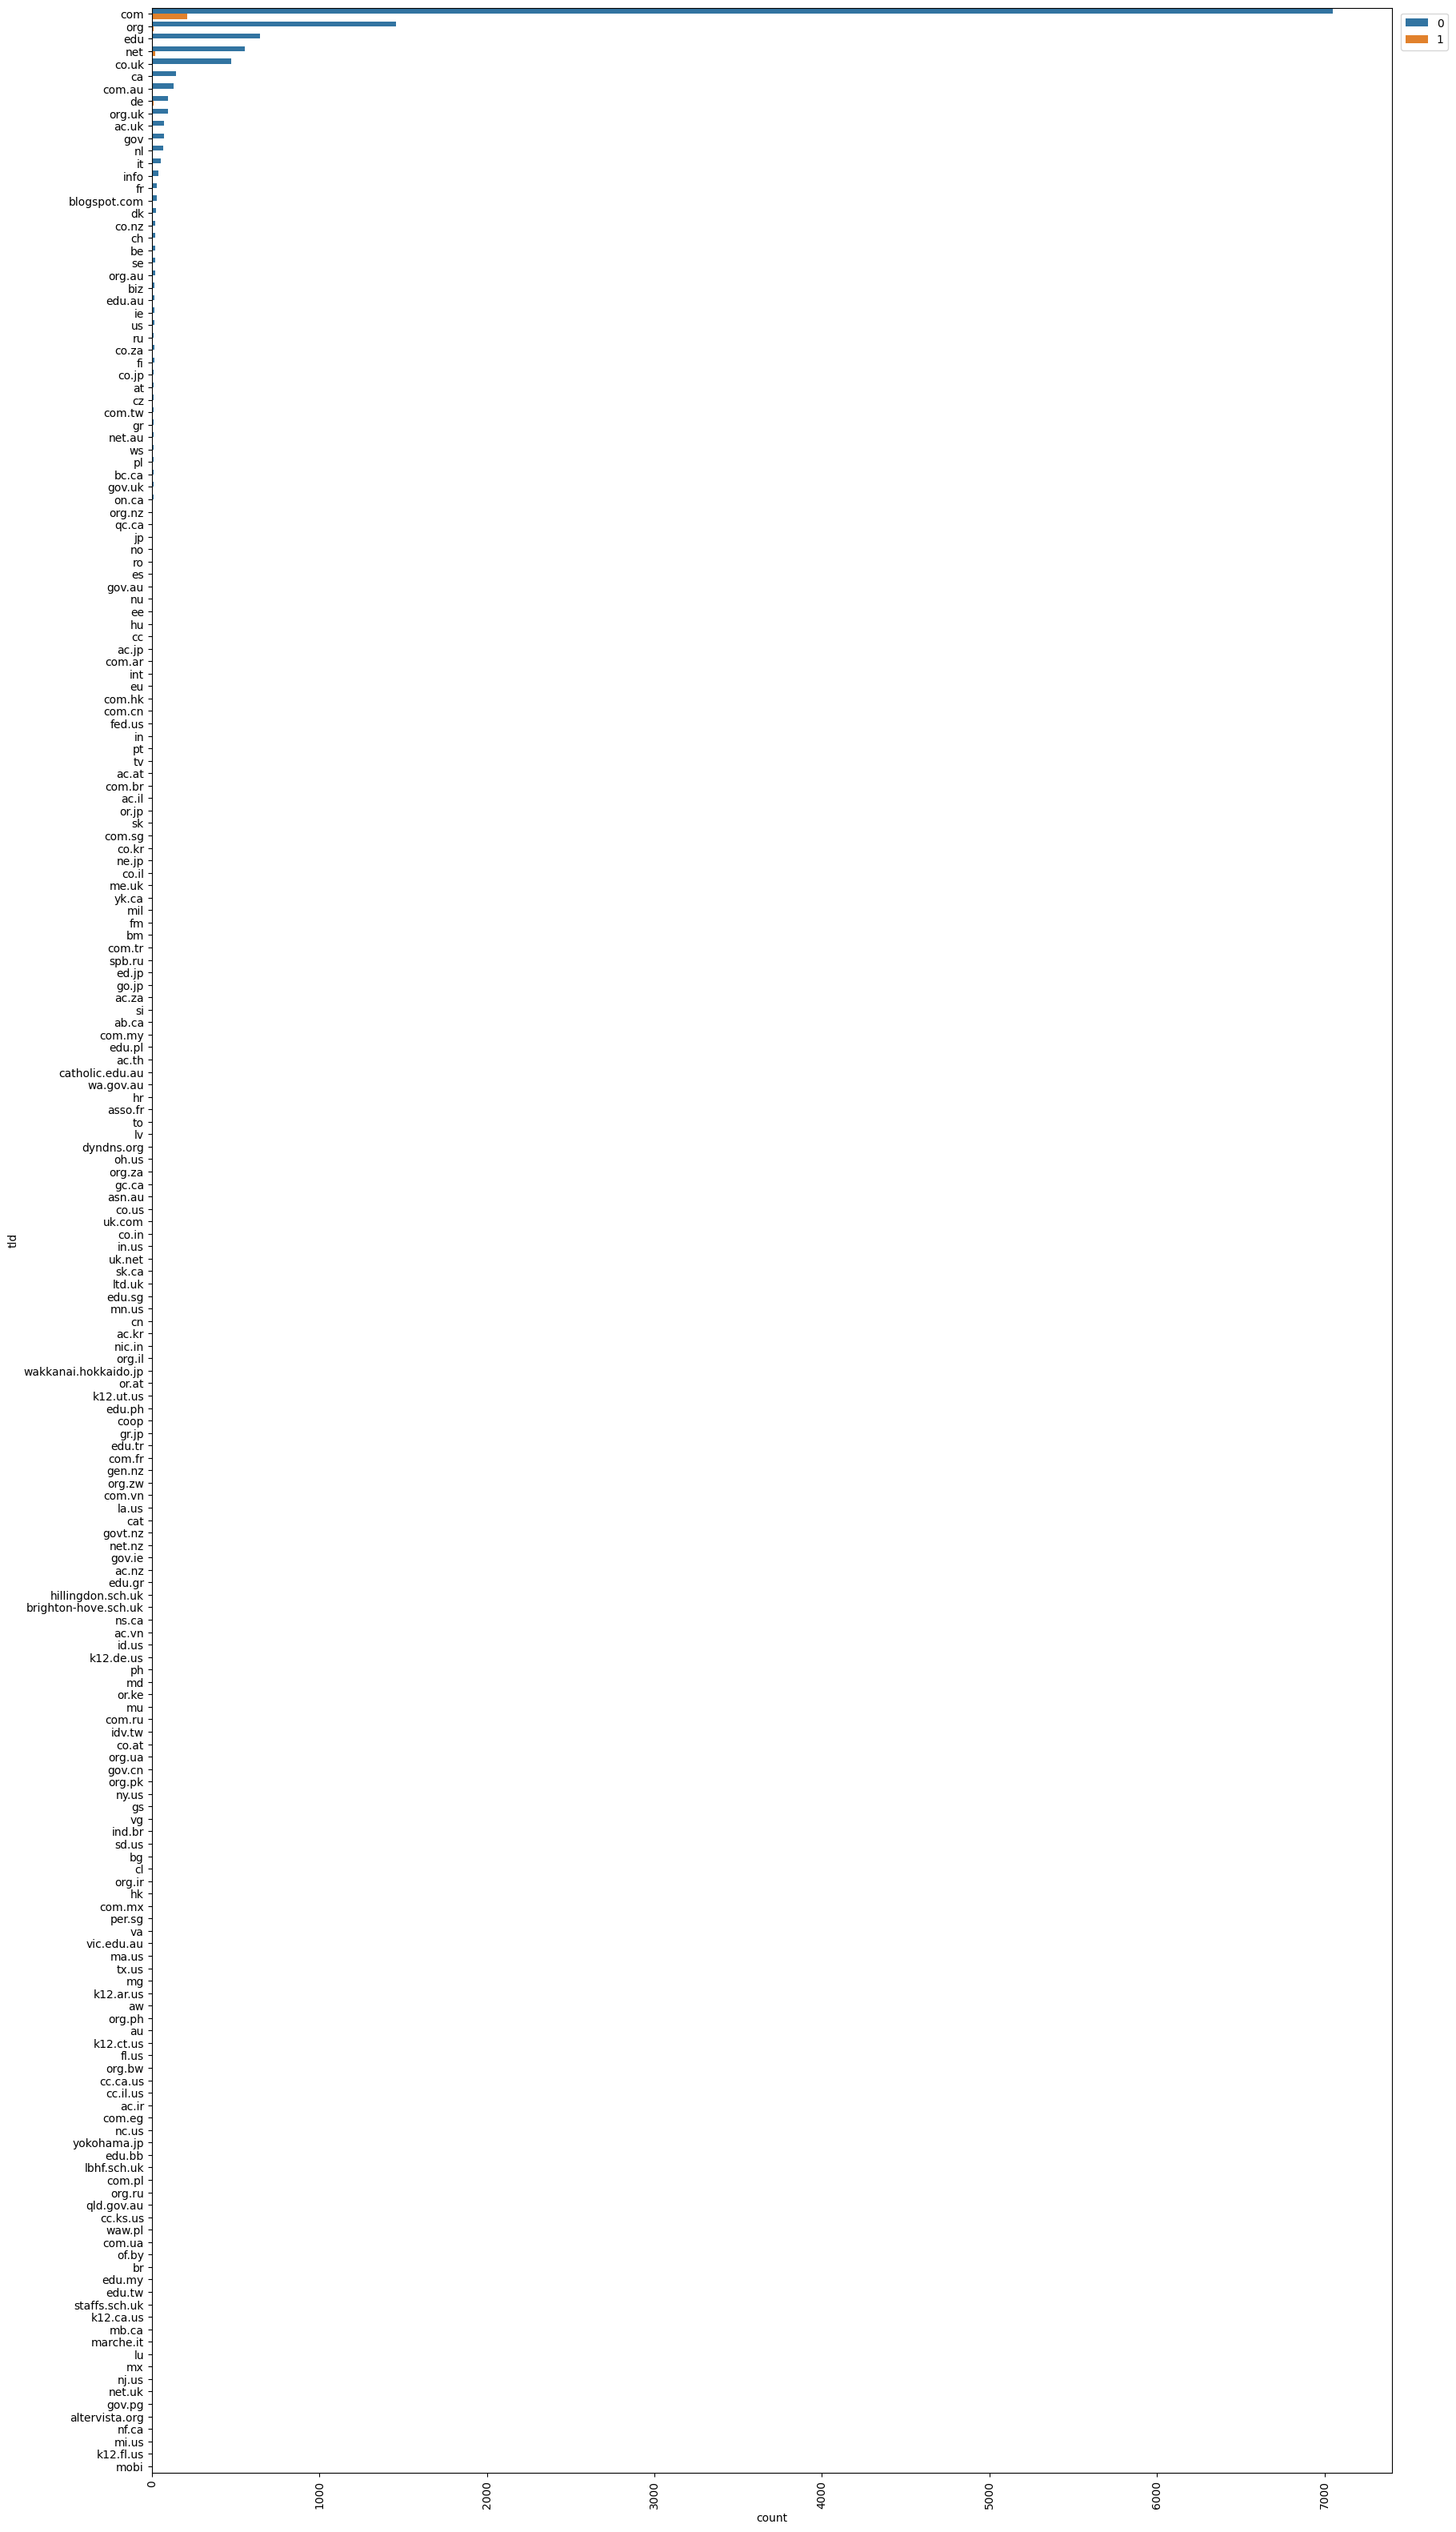

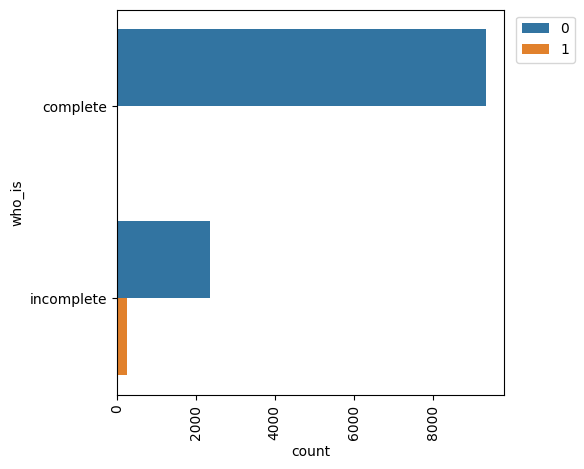

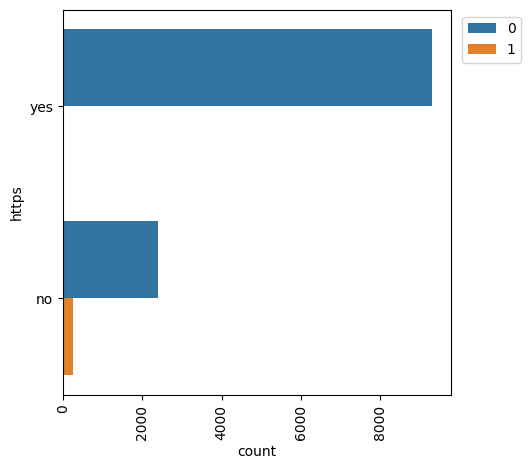

In [40]:
for i, col in enumerate(cat_cols):
    if(col not in ['url','ip_add','content']):
        if (col == 'geo_loc'):
            plt.figure(i, figsize = (20,40))
            sns.countplot(y=col, order=train[col].value_counts().index, data=train, hue="label")
            plt.xticks(rotation=90)
            plt.legend(loc='upper right', bbox_to_anchor=(1.05, 1))
            plt.show()
        
        else:
            if(col == 'tld'):
                plt.figure(i,figsize = (20,40))
                sns.countplot(y=col, data=train, order=train[col].value_counts().index,hue="label")
                plt.xticks(rotation=90)
                plt.legend(loc='upper right', bbox_to_anchor=(1.05, 1))
                plt.show()
            
            else:   
                plt.figure(i,figsize = (5,5))
                sns.countplot(y=col, data=train, hue="label")
                plt.xticks(rotation=90)
                plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
                plt.show()
    else:
        pass
 

In [41]:
(train[train["label"]==0]["geo_loc"].value_counts().nlargest(10)/train[train["label"]==0]["geo_loc"].shape[0])

United States     0.433325
China             0.094617
Japan             0.054347
Germany           0.035833
South Korea       0.034639
United Kingdom    0.031055
Brazil            0.024742
France            0.023036
Canada            0.018428
Italy             0.016296
Name: geo_loc, dtype: float64

In [42]:
(train[train["label"]==1]["geo_loc"].value_counts().nlargest(10)/train[train["label"]==1]["geo_loc"].shape[0])

United States    0.426523
China            0.096774
Japan            0.075269
South Korea      0.035842
Germany          0.028674
Russia           0.028674
Brazil           0.028674
Italy            0.025090
Canada           0.017921
Colombia         0.017921
Name: geo_loc, dtype: float64

In [43]:
((train[train["label"]==1]["geo_loc"].value_counts()/train[train["label"]==1]["geo_loc"].shape[0])*100).nlargest(5).sum()

66.30824372759857

In [44]:
(train[train["label"]==1]["tld"].value_counts().nlargest(10)/train[train["label"]==1]["tld"].shape[0])*100

com      75.268817
net       6.810036
org       3.225806
de        3.225806
co.uk     1.792115
jp        1.075269
nl        1.075269
ru        1.075269
fr        0.716846
co.jp     0.716846
Name: tld, dtype: float64

In [45]:
((train[train["label"]==1]["tld"].value_counts()/train[train["label"]==1]["tld"].shape[0])*100).nlargest(4).sum()

88.53046594982078

In [46]:
(train[train["label"]==0]["tld"].value_counts().nlargest(10)/train[train["label"]==0]["tld"].shape[0])*100

com       60.131388
org       12.447743
edu        5.520007
net        4.726559
co.uk      4.044024
ca         1.254159
com.au     1.100589
de         0.827574
org.uk     0.819043
ac.uk      0.639877
Name: tld, dtype: float64

In [47]:
((train[train["label"]==0]["tld"].value_counts()/train[train["label"]==0]["tld"].shape[0])*100).nlargest(4).sum()

82.82569746608651

**Observations**
- **geo_loc**: Webpages from US, China, Japan, Germany, South Korea account for majority of malicious webpages considered as well as good webpages.<br>
     
- **tld**: 
    - Label 0: .com, .org, .edu, .net top level domains account for 82.82% of Good webpages  considered
    - Label 1: .com, .org, .de, .net top level domains account for 88.53% of malicious webpages  considered  <br>   
    
- **who_is**: 
    - Label 0: All Good webpages had complete who_is information
    - Label 1: Malicious webpages in comparison had some incomplete information  <br>
 
- **https**:  
    - Label 0: Almost all of Good webpages used https. This is as expected
    - Label 1: Some Malicious webpages in comparison did not use https. However, majority malicious websites did use https  
  

In [48]:
pd.crosstab(train['geo_loc'], train.label, normalize='index') # Percentage webpages which are good and bad wrt geo_loc(country)

label              0         1
geo_loc                       
Albania     1.000000  0.000000
Algeria     0.933333  0.066667
Andorra     1.000000  0.000000
Angola      0.857143  0.142857
Anguilla    1.000000  0.000000
...              ...       ...
Uzbekistan  1.000000  0.000000
Venezuela   0.967742  0.032258
Vietnam     0.985915  0.014085
Zambia      1.000000  0.000000
Zimbabwe    1.000000  0.000000

[139 rows x 2 columns]

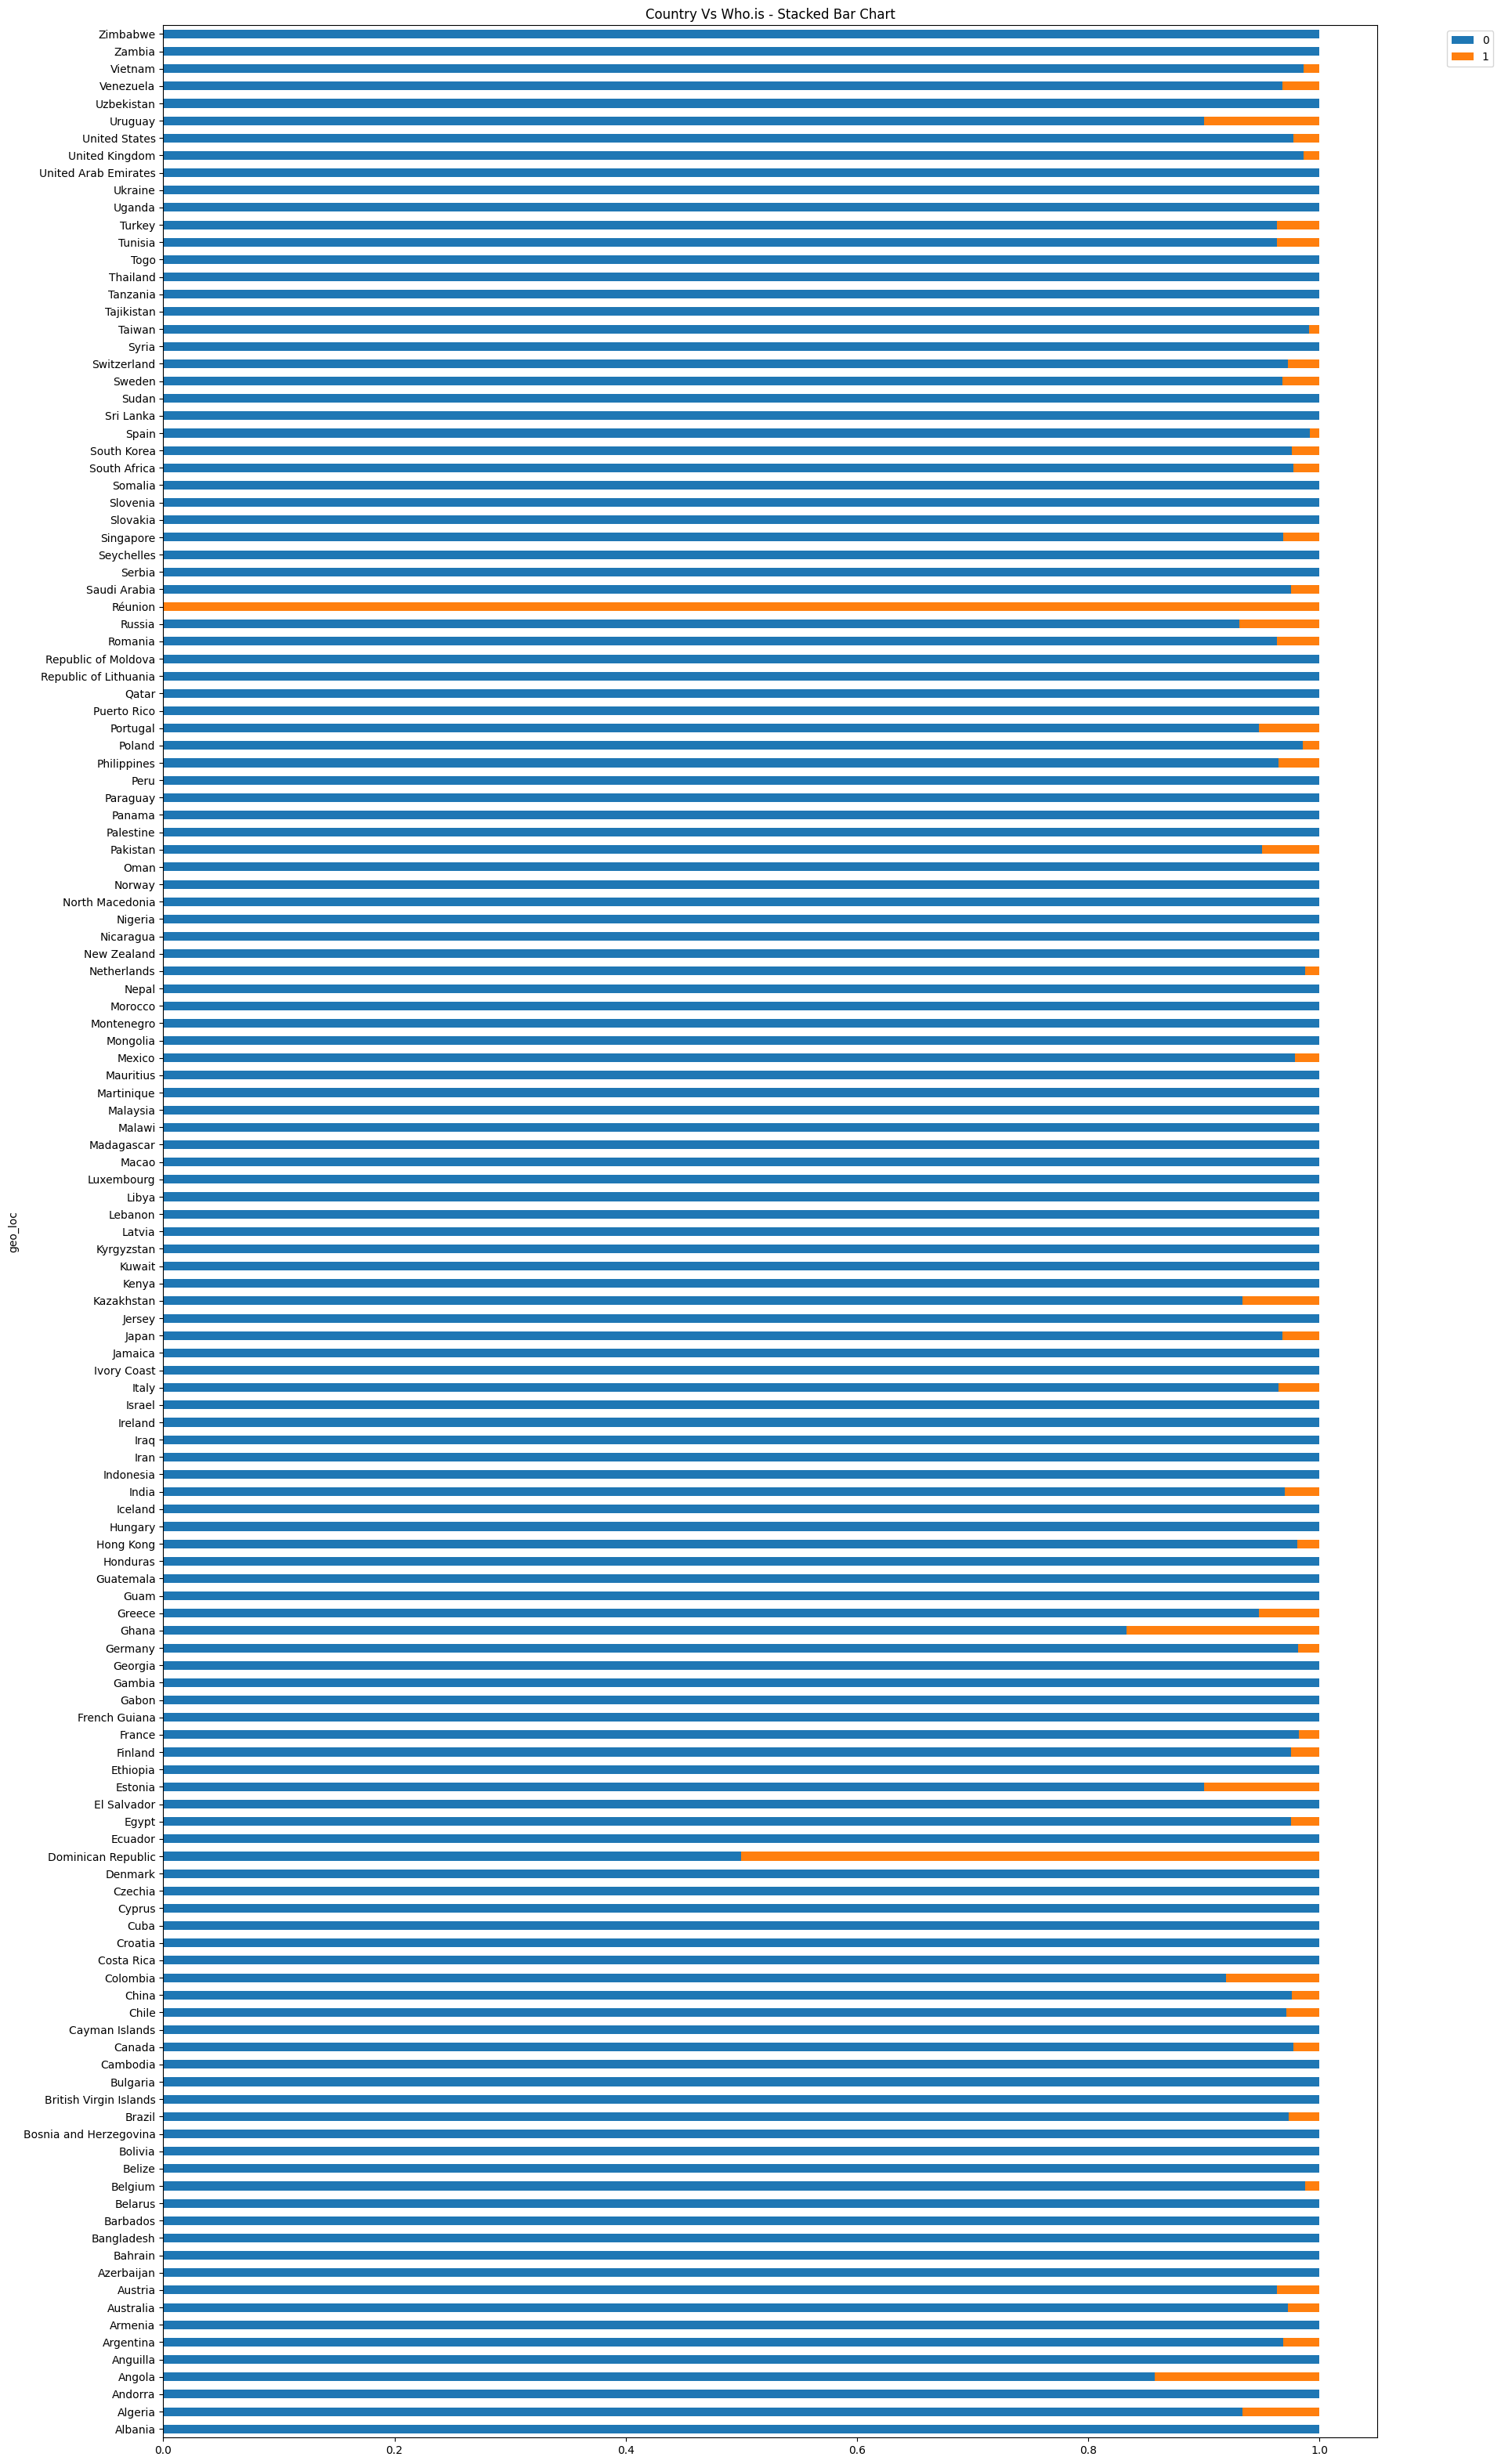

In [49]:
pd.crosstab(train['geo_loc'], train.label, normalize='index').plot(kind='barh', 
                                                                   stacked=True, figsize = (20,40))
plt.title("Country Vs Who.is - Stacked Bar Chart")
 
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
plt.show()

**Observation**
- Reunion (Réunion Island) webpages considered in the dataset were all malicious.
- Approximately, 50% Dominican Republic webpages were malicious and 50% were good

In [50]:
pd.crosstab(train['geo_loc'], train.who_is, normalize='index')

who_is      complete  incomplete
geo_loc                         
Albania     0.000000    1.000000
Algeria     0.866667    0.133333
Andorra     1.000000    0.000000
Angola      0.714286    0.285714
Anguilla    1.000000    0.000000
...              ...         ...
Uzbekistan  0.500000    0.500000
Venezuela   0.741935    0.258065
Vietnam     0.732394    0.267606
Zambia      0.800000    0.200000
Zimbabwe    0.000000    1.000000

[139 rows x 2 columns]

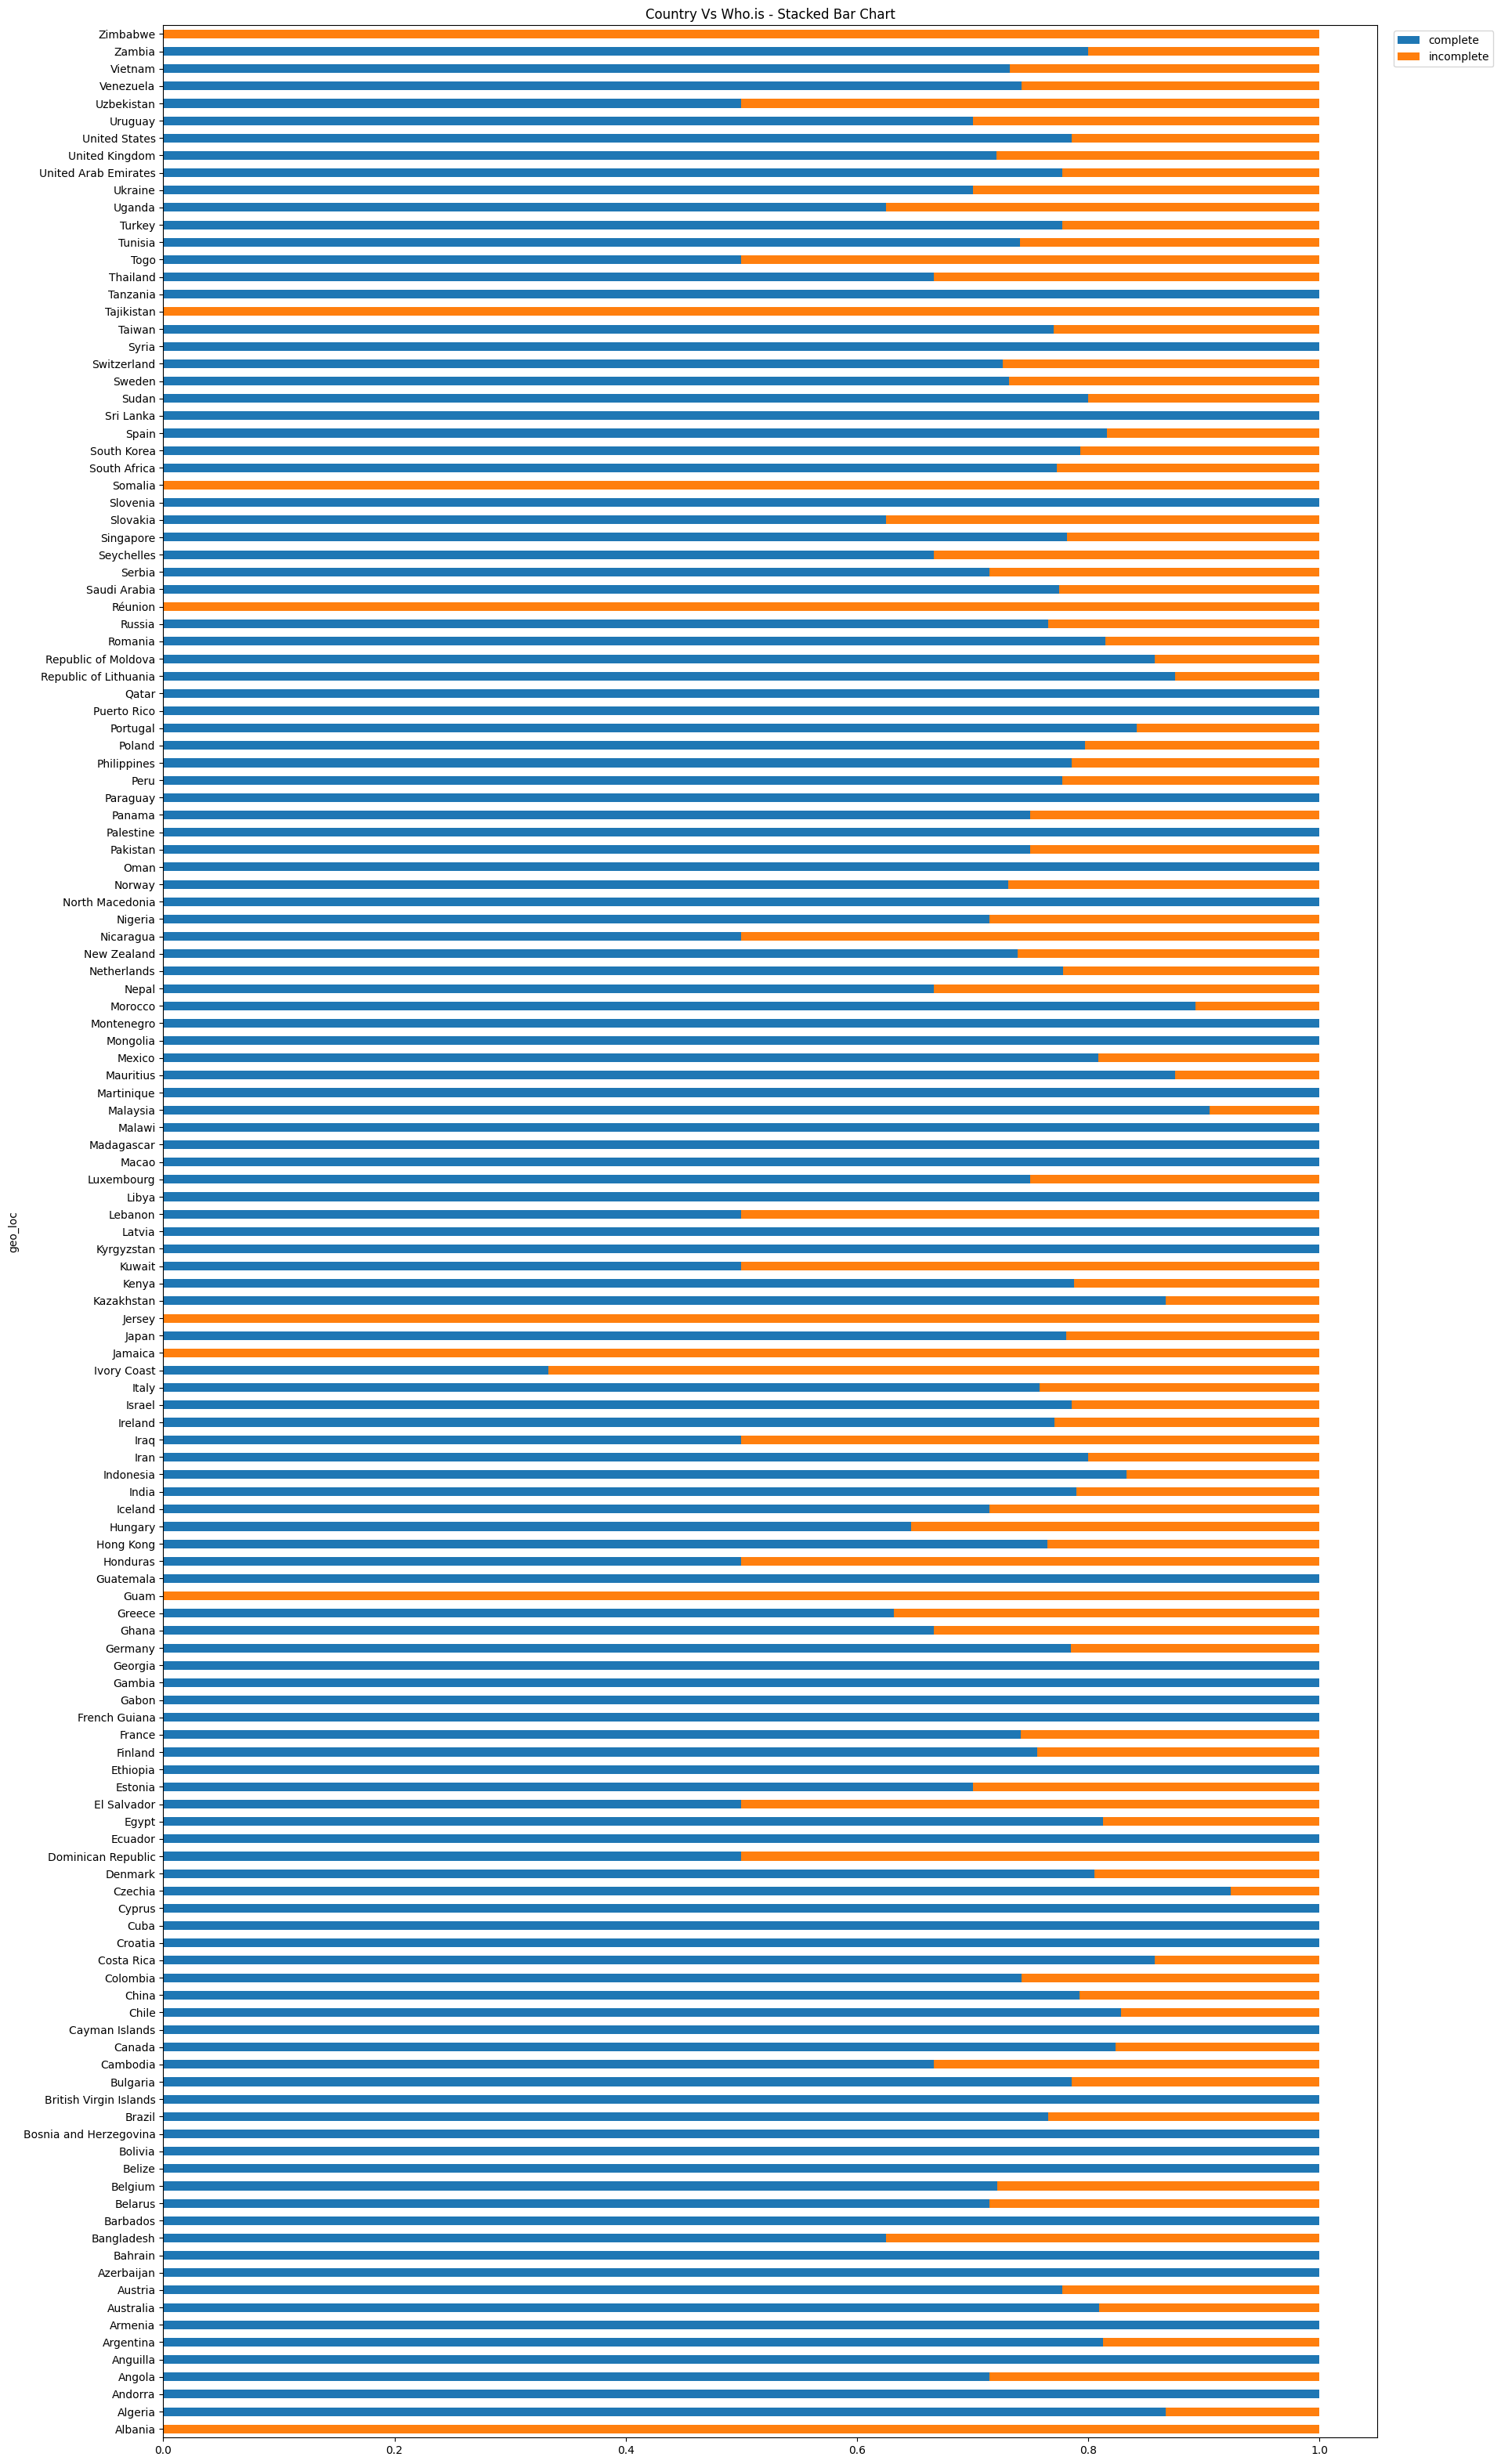

In [51]:
pd.crosstab(train['geo_loc'], train.who_is, normalize='index').plot(kind='barh', sort_columns=True,
                                                                   stacked=True, figsize = (20,40))
plt.title("Country Vs Who.is - Stacked Bar Chart")
 
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
plt.show()

**Observation**
- Webpages from Reunion (Réunion Island), Albania, Guam, Jamaica, Jersey, Somalia, Tajikistan and Zimbabwe had incomplete who_is information
- Majority Webpages from Bangladesh, Dominican Republic, El-Salvador, Honduras, Iraq, Ivory Coast, Kyrgyzstan, Lebabon, Nigeria, Toga  and Uzbekistan had incomplete who_is information

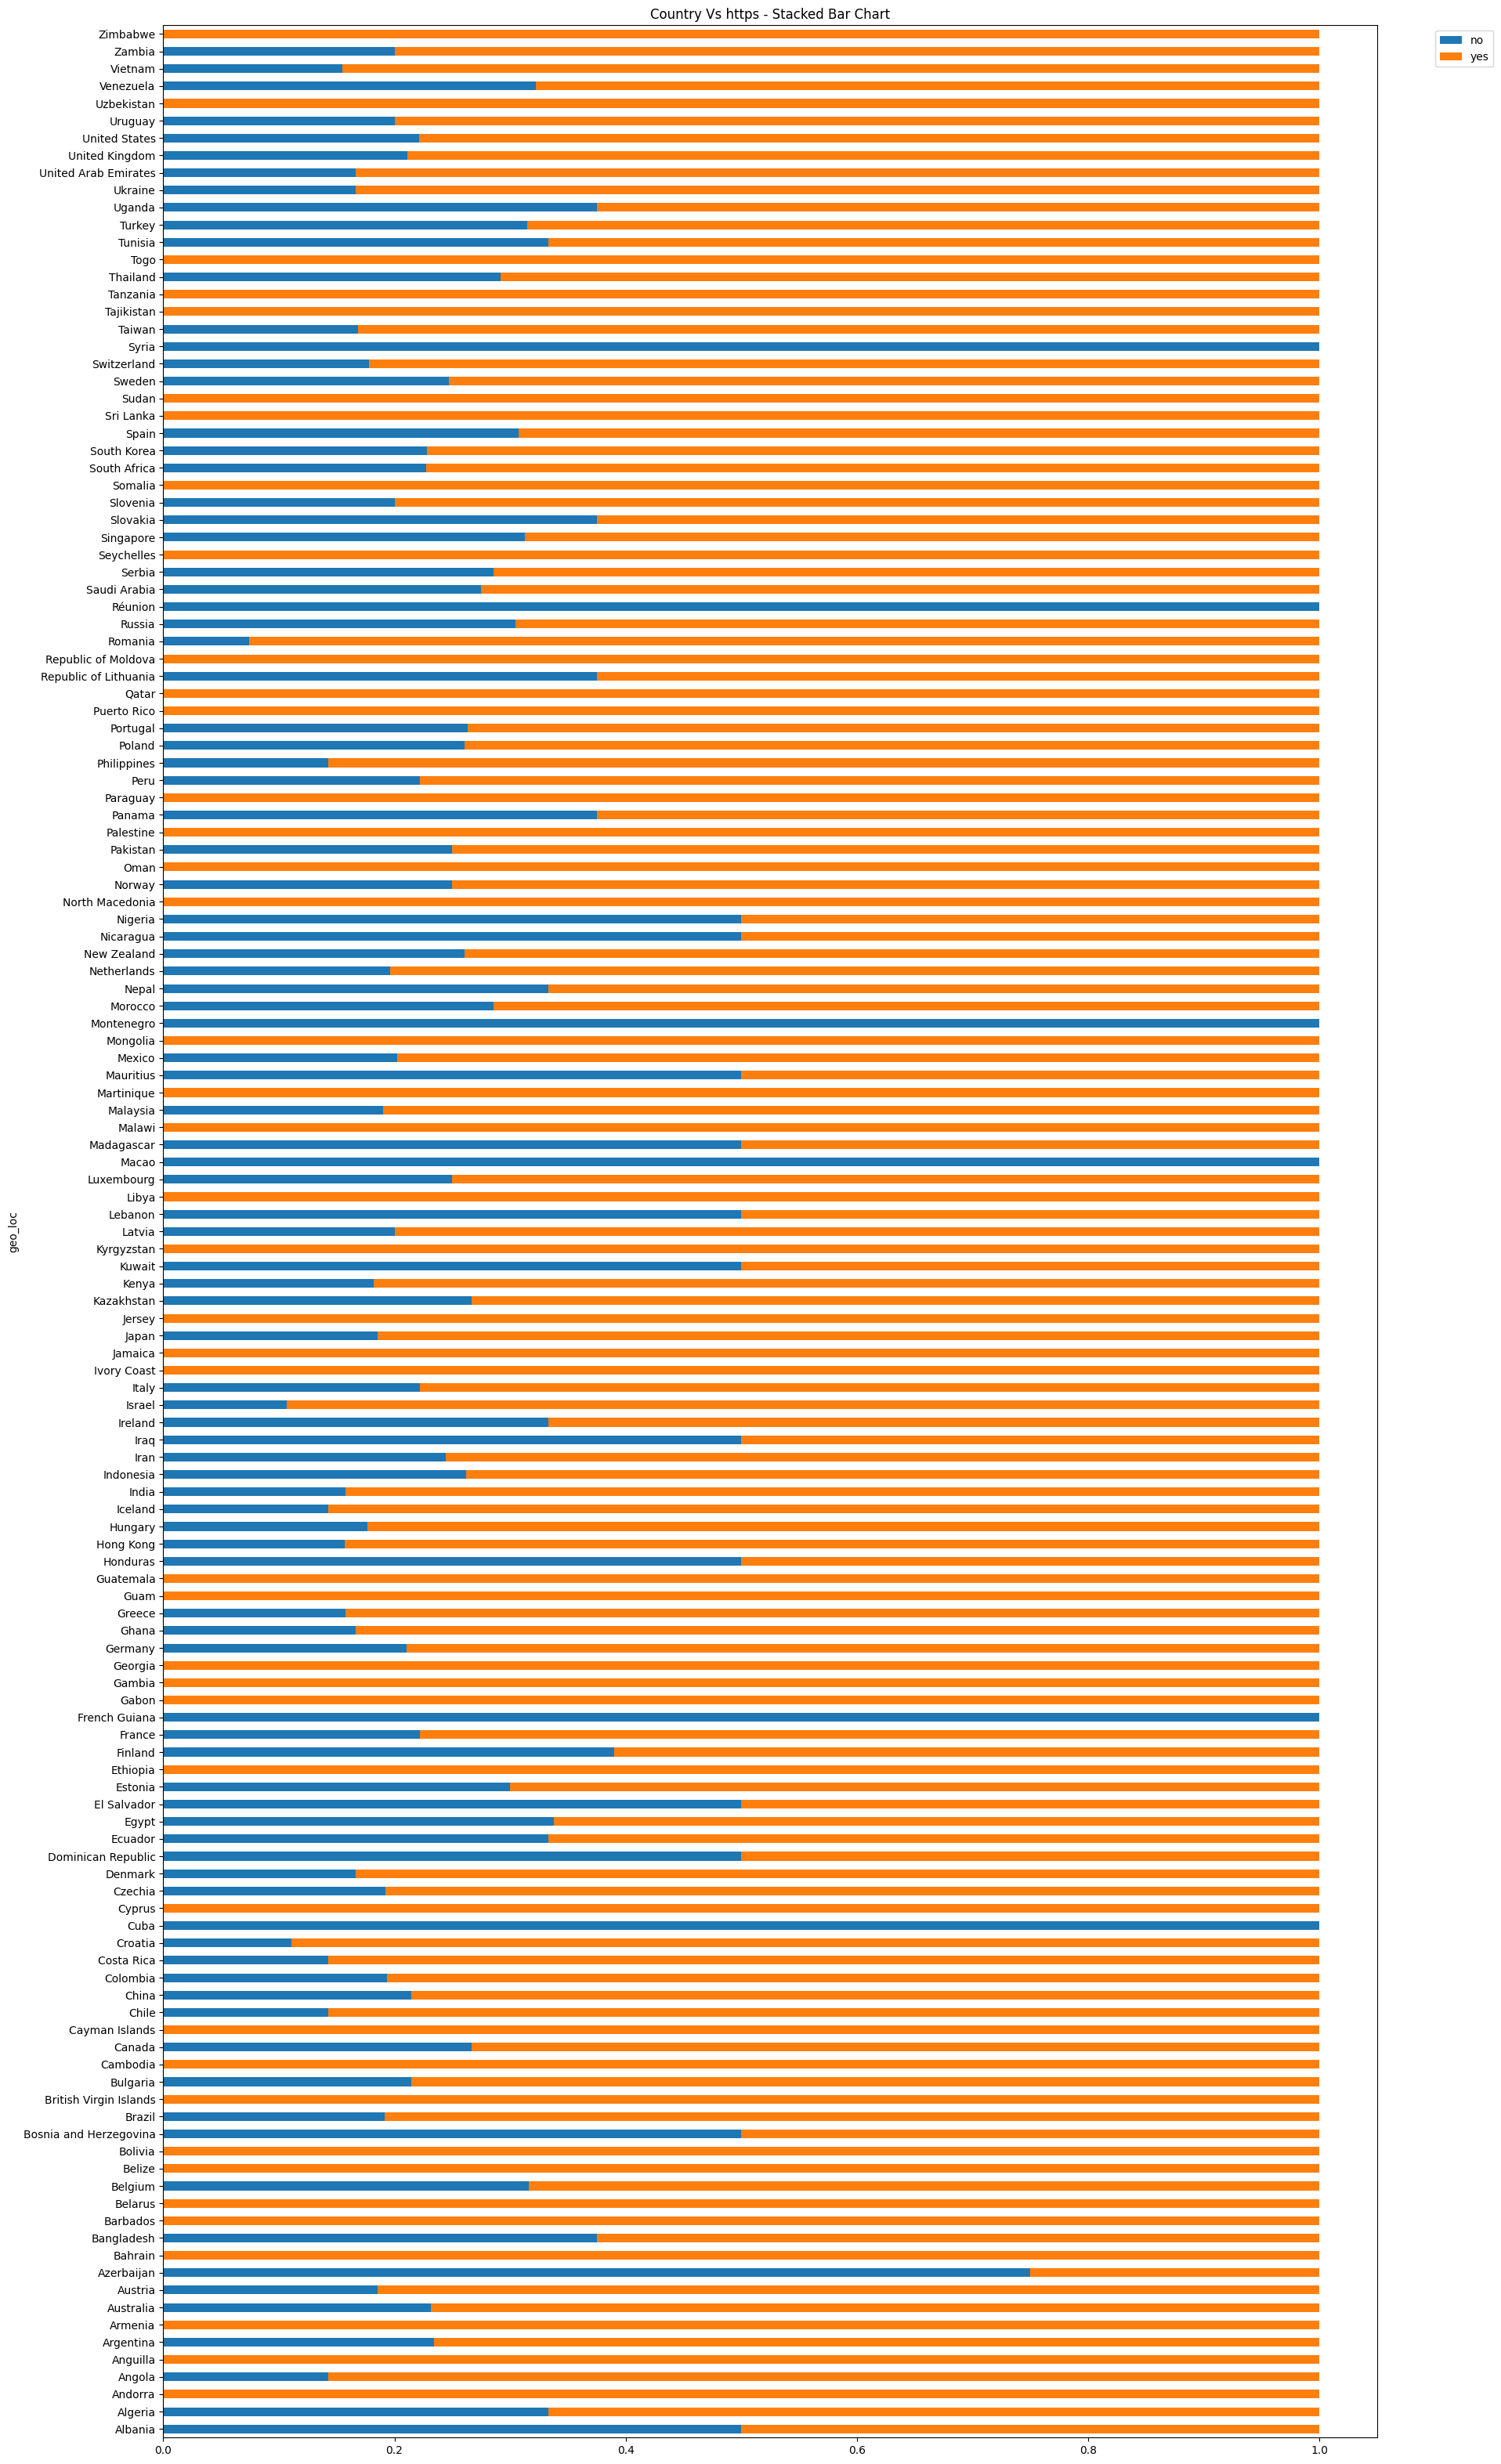

In [52]:
pd.crosstab(train['geo_loc'], train.https, normalize='index').plot(kind='barh', 
                                                                   stacked=True, figsize = (20,40))
plt.title("Country Vs https - Stacked Bar Chart")
 
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
plt.show()

**Observation**
- Webpages from Cuba, French Guiana, Macao, Montenegro, Reunion (Réunion Island), Syria did not use https at all. 

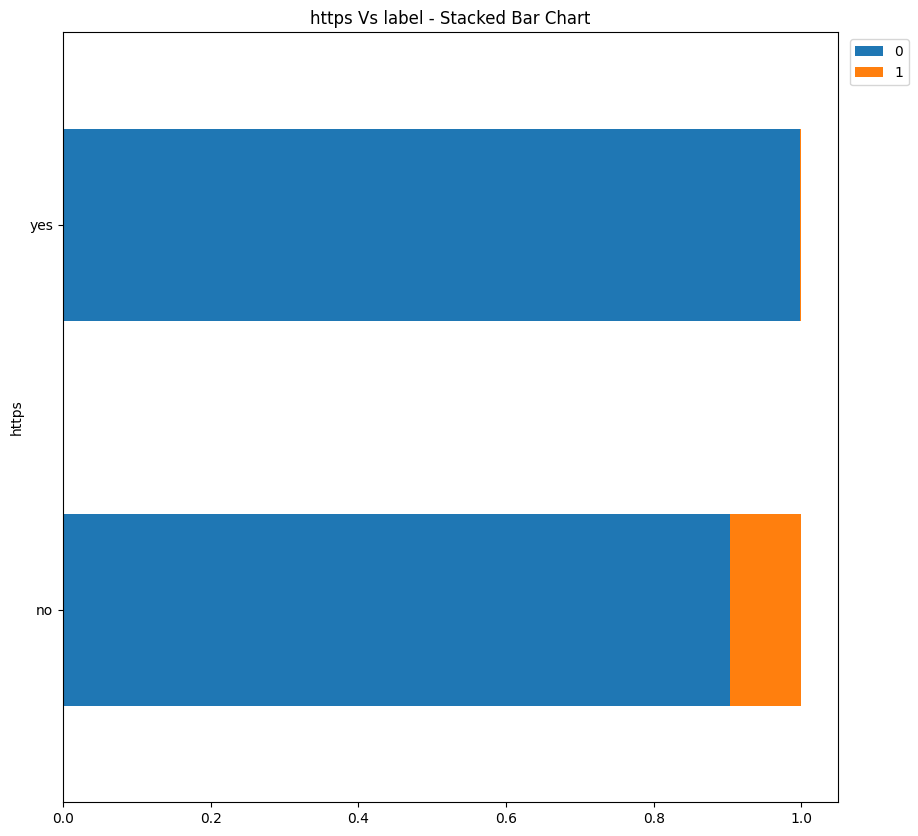

In [53]:
pd.crosstab(train['https'], train.label, normalize='index').plot(kind='barh', 
                                                                   stacked=True, figsize = (10,10))
plt.title("https Vs label - Stacked Bar Chart")
 
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
plt.show()

**Observation**
- **https**:  
    - Label 0: Almost all of Good webpages used https. This is as expected
    - Label 1: Some Malicious webpages in comparison did not use https. However, majority malicious websites did use https  
  

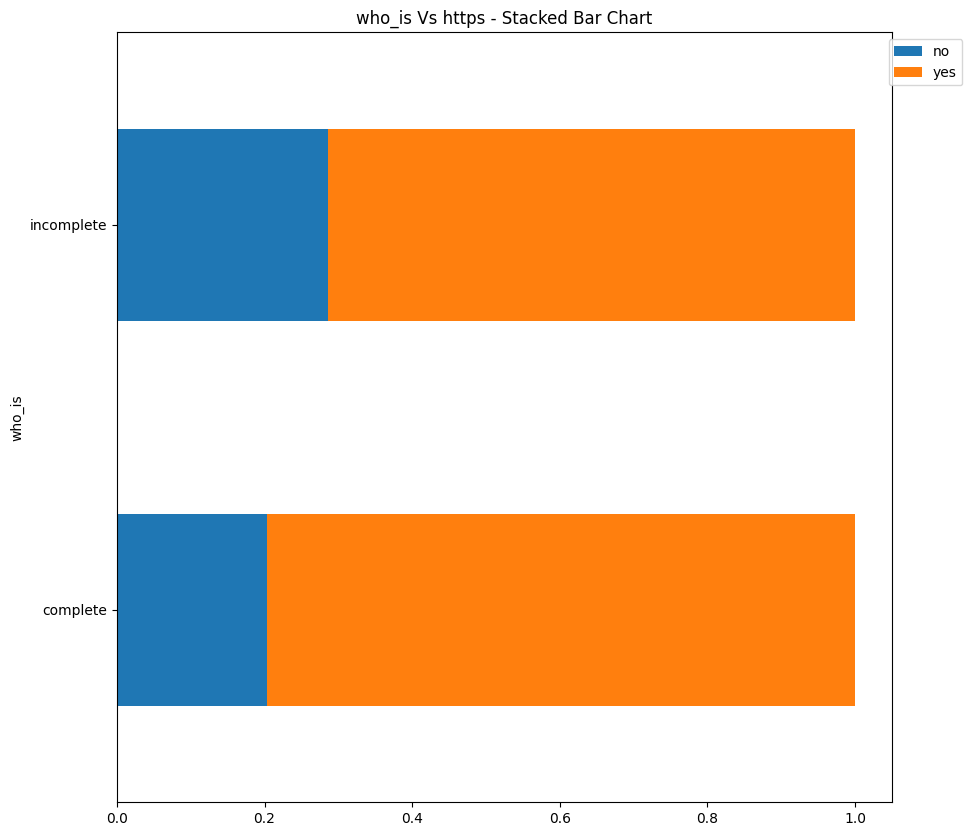

In [54]:
pd.crosstab(train['who_is'], train.https, normalize='index').plot(kind='barh', 
                                                                   stacked=True, figsize = (10,10))
plt.title("who_is Vs https - Stacked Bar Chart")
 
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
plt.show()

**Observation**

- **who_is vs https**: Majority of the webpages, whether who_is information complete or other otherwise used https.
 

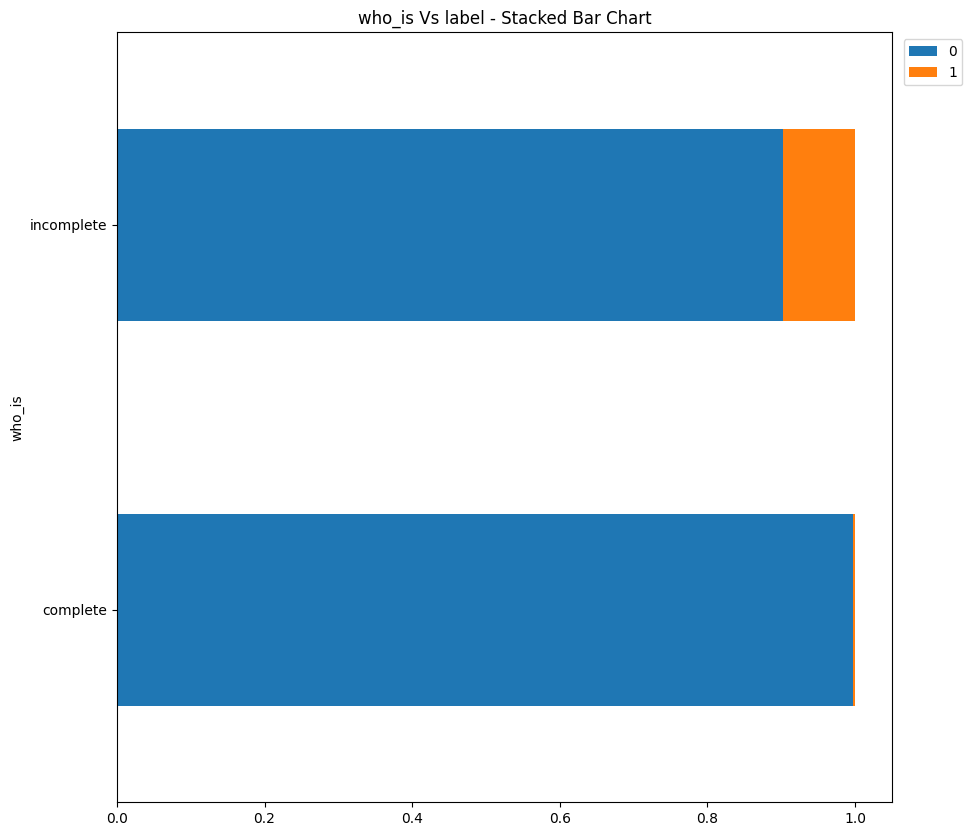

In [55]:
pd.crosstab(train['who_is'], train.label, normalize='index').plot(kind='barh', 
                                                                   stacked=True, figsize = (10,10))
plt.title("who_is Vs label - Stacked Bar Chart")
 
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
plt.show()

**Observation**

- **who_is vs label**: Almost all webpages which had who_is complete were good webpages. 
 

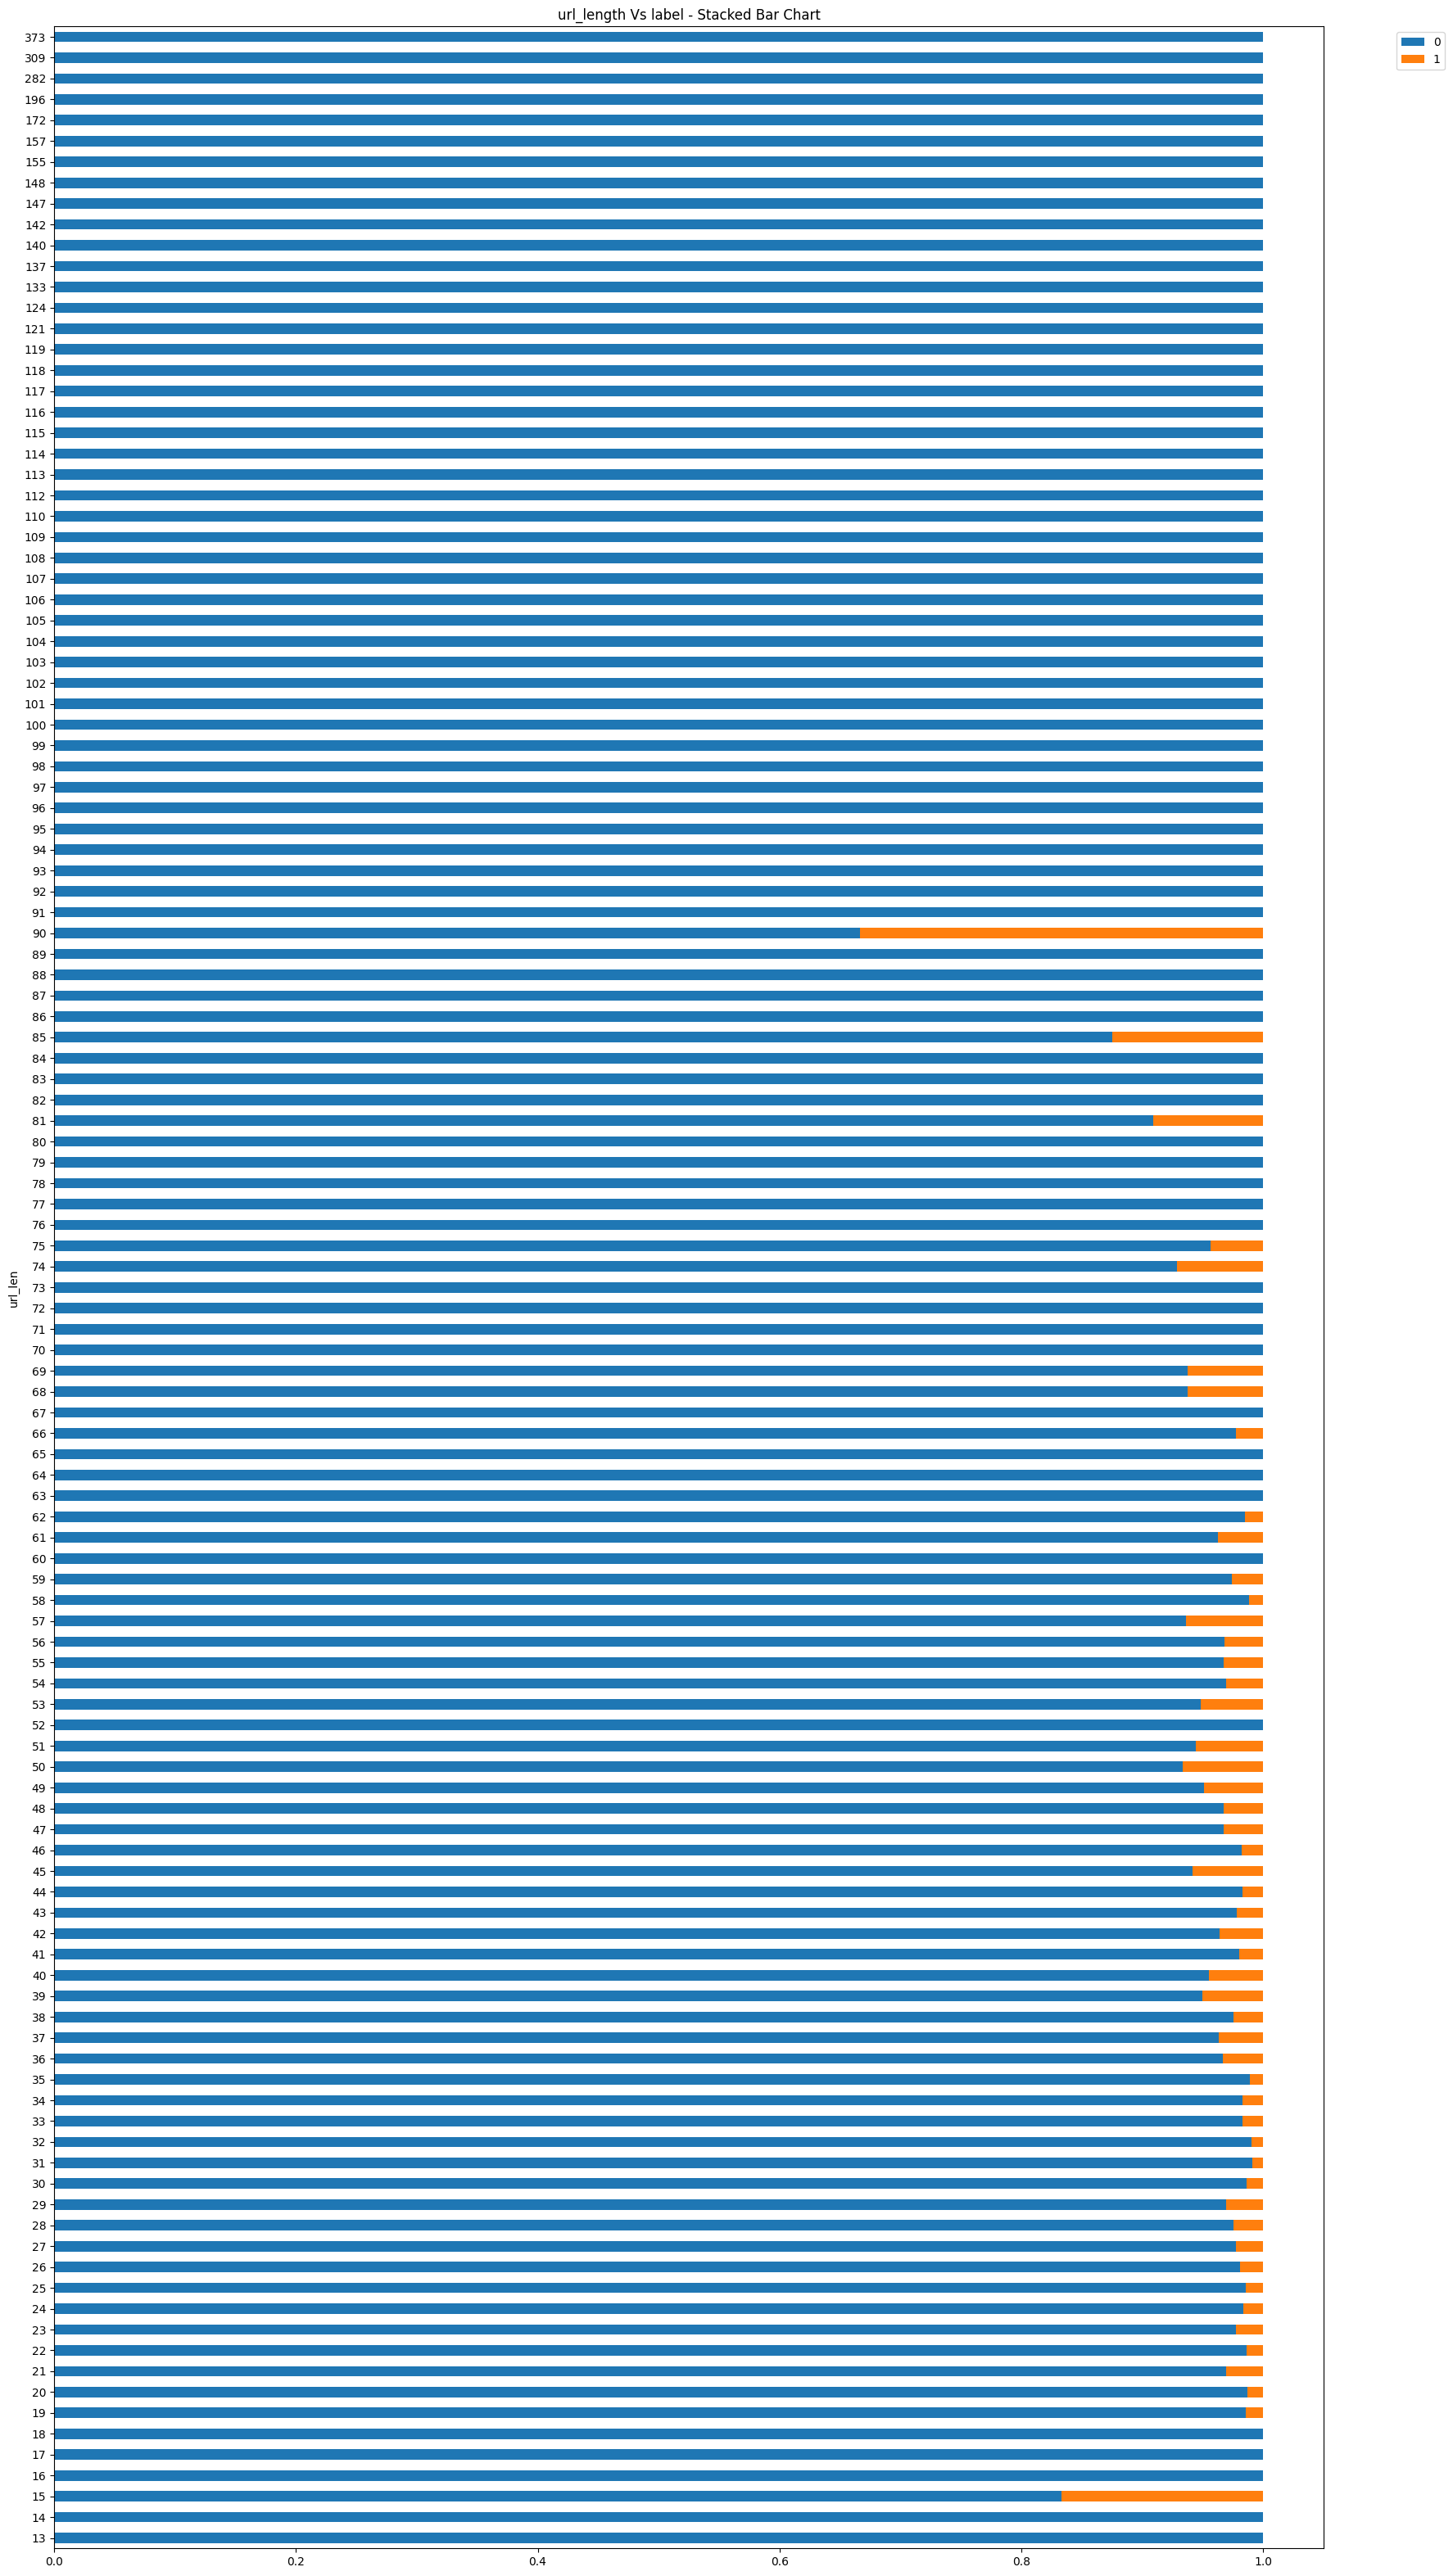

In [56]:
pd.crosstab(train['url_len'], train.label, normalize='index').plot(kind='barh', 
                                                                   stacked=True, figsize = (20,40))
plt.title("url_length Vs label - Stacked Bar Chart")
 
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
plt.show()

**Observation**

- **url_len vs label**: url_len doesn't seem to be a good estimator of label
 

# Data Extraction from content and url features

## Data Extraction from url feature

In [57]:
# Here is I generated columns from the url based on the presence of the below symbols and Sub-domains and multi level subdomain. 
# 1. Asperand(@) Symbol - 
# 2. Redirection(//) Symbol
# 3. Hyphen(-) Symbol
# 4. Sub-domains and multi level subdomains

In [58]:
# Asperand(@) Symbol
train["asperand_symbol"] = np.where(train['url'].str.contains("@"), 1, 0)
train["asperand_symbol"].value_counts()

0    11996
1        4
Name: asperand_symbol, dtype: int64

In [59]:
# Redirection(//) Symbol
train["redirection_symbol"] = np.where(train['url'].str.removeprefix("http://").str.removeprefix("https://").str.contains("//"),
                                        1, 0)
train["redirection_symbol"].value_counts()

0    11995
1        5
Name: redirection_symbol, dtype: int64

In [60]:
# Hyphen(-) Symbol

from urllib.parse import urlparse
train["hyphen_symbol"] = np.where(train["url"].apply(lambda x: urlparse(x).netloc).str.contains("-"), 1, 0)
train["hyphen_symbol"].value_counts()

0    11072
1      928
Name: hyphen_symbol, dtype: int64

In [61]:
# Sub-domains and multi level subdomains
 
train["multilevel_subdomains"] = np.where(train["url"].apply(lambda x: urlparse(x).netloc).str.count("\.") > 3, 1, 0)
train["multilevel_subdomains"].value_counts()

0    11829
1      171
Name: multilevel_subdomains, dtype: int64

In [62]:
# Here is I generated columns from the content based on its length, the presence of the <iframe> tags and
# no. of times <iframe> tag, find() and eval() functions were used in the content


In [63]:
train['content_len'] = train["content"].str.len()

In [64]:
train.insert(len(train.columns)-1, 'label', train.pop('label')) # Moving label to the last column in the dataframe
train.columns

Index(['url', 'url_len', 'ip_add', 'geo_loc', 'tld', 'who_is', 'https',
       'js_len', 'js_obf_len', 'content', 'asperand_symbol',
       'redirection_symbol', 'hyphen_symbol', 'multilevel_subdomains',
       'content_len', 'label'],
      dtype='object')

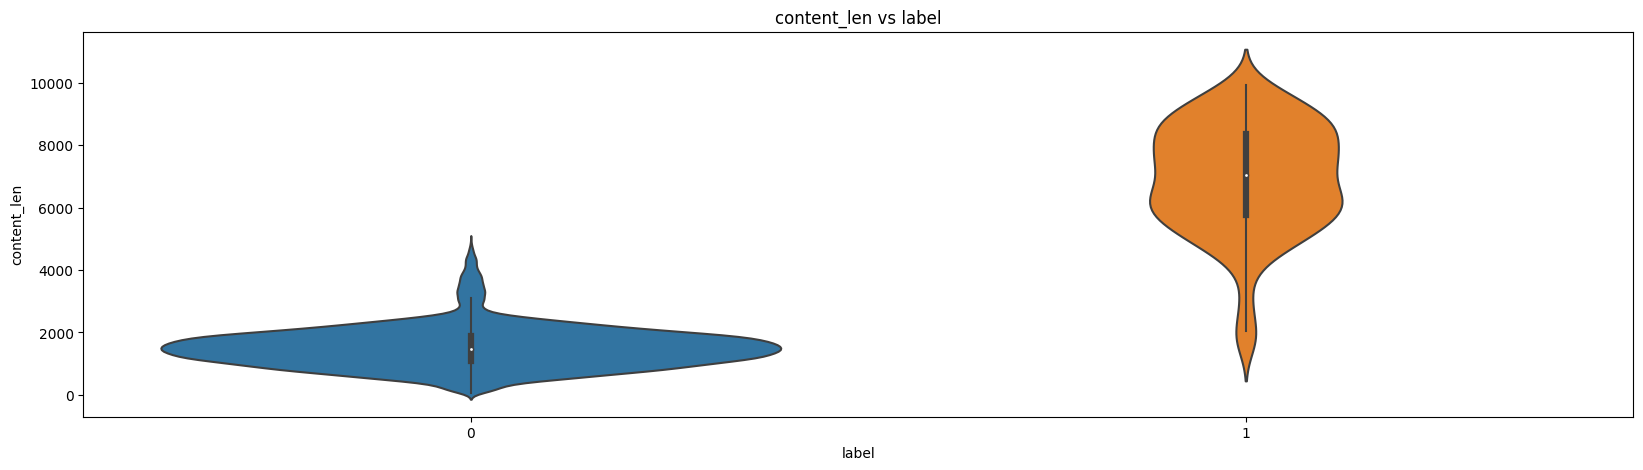

In [65]:
# Plotting content_len vs label 
plt.figure(figsize = (20,5))
sns.violinplot(x='label',y='content_len', data=train)
plt.title("content_len vs label")
plt.show()

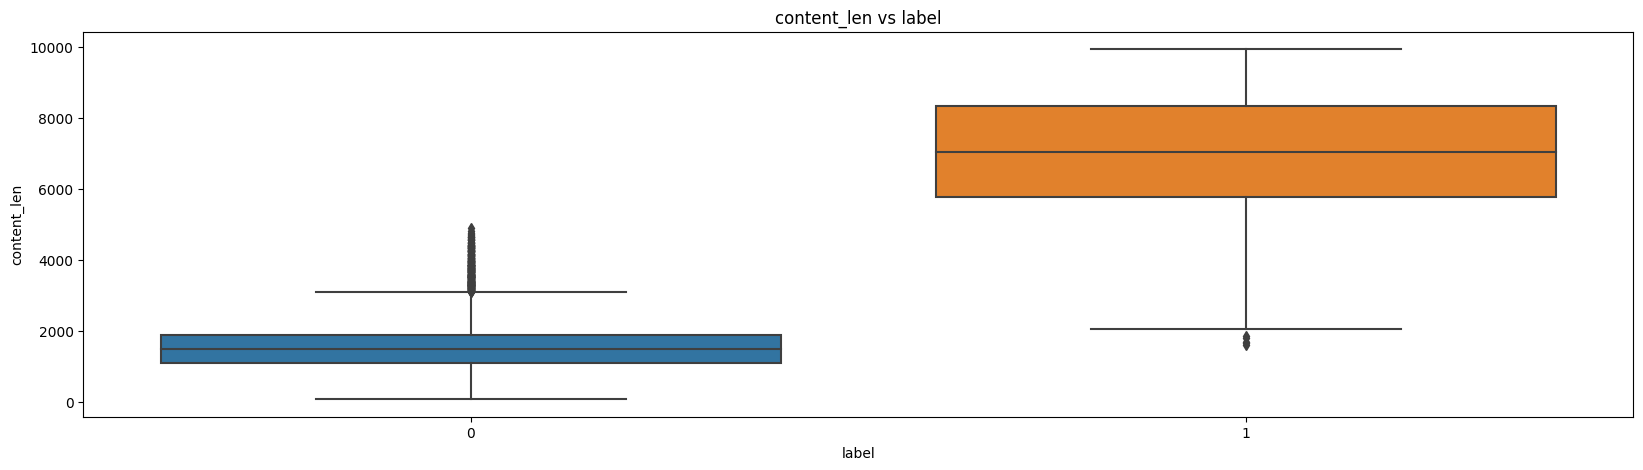

In [66]:
plt.figure(figsize = (20,5))
sns.boxplot(x='label',y='content_len', data=train)
plt.title("content_len vs label")
plt.show()

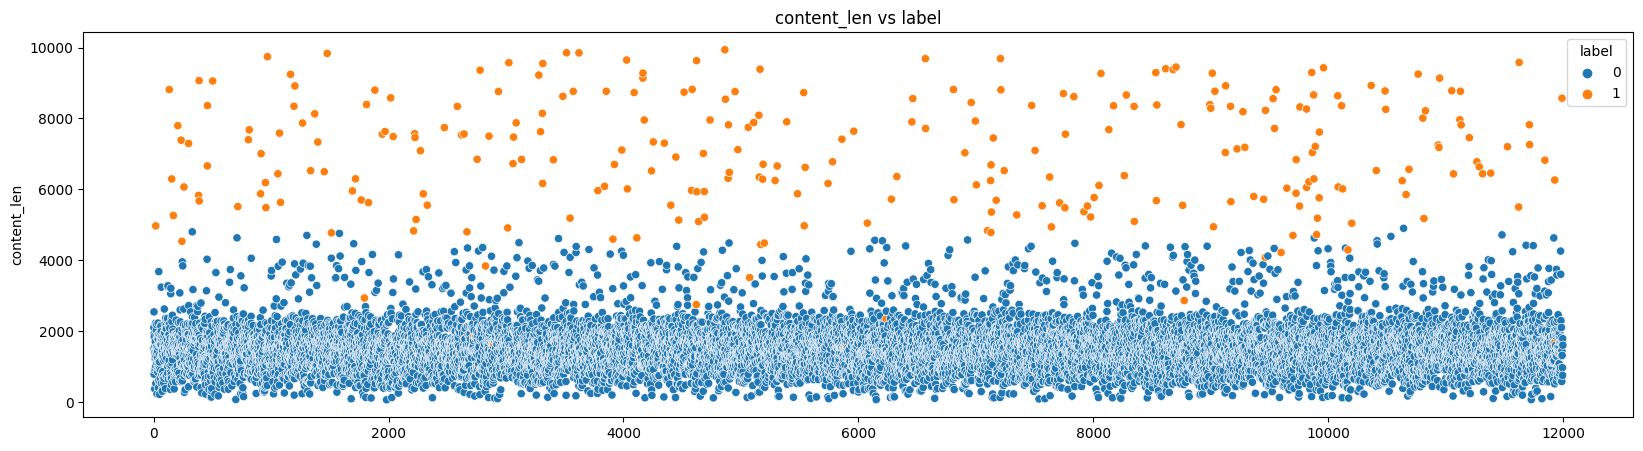

In [67]:
plt.figure(figsize = (20,5))
sns.scatterplot(x=train.index.values,y='content_len', data=train, hue="label")
plt.title("content_len vs label")
plt.show()

**From the above plots, it looks like content_len is also a good candidate for predictor of label**

In [68]:
# Presence of iframe
train["iframe"] = np.where(train['content'].str.findall("<iframe>"), 1, 0)
train["iframe"].value_counts()

0    10228
1     1772
Name: iframe, dtype: int64

In [69]:
# No. of iframes 
train["no_of_iframes"]= train["content"].str.findall("<iframe>").apply(lambda x: len(x)) 
train["no_of_iframes"].value_counts()

0    10228
1     1643
2      125
3        4
Name: no_of_iframes, dtype: int64

In [70]:
# No. of find() fns used
train["no_of_find_fn"] = train["content"].str.findall("find\(\)").apply(lambda x: len(x)) 
train["no_of_find_fn"].value_counts()

0     3839
1     3496
2     2434
3     1259
4      535
5      198
6       79
7       59
9       27
8       23
10      17
11      15
12      12
13       5
15       1
14       1
Name: no_of_find_fn, dtype: int64

In [71]:
# No. of eval() fns used
train["no_of_eval_fn"] = train["content"].str.findall("eval\(\)").apply(lambda x: len(x)) 
train["no_of_eval_fn"].value_counts()

0     5187
1     3812
2     1911
3      655
4      245
5       94
6       39
7       29
8       21
9        6
10       1
Name: no_of_eval_fn, dtype: int64

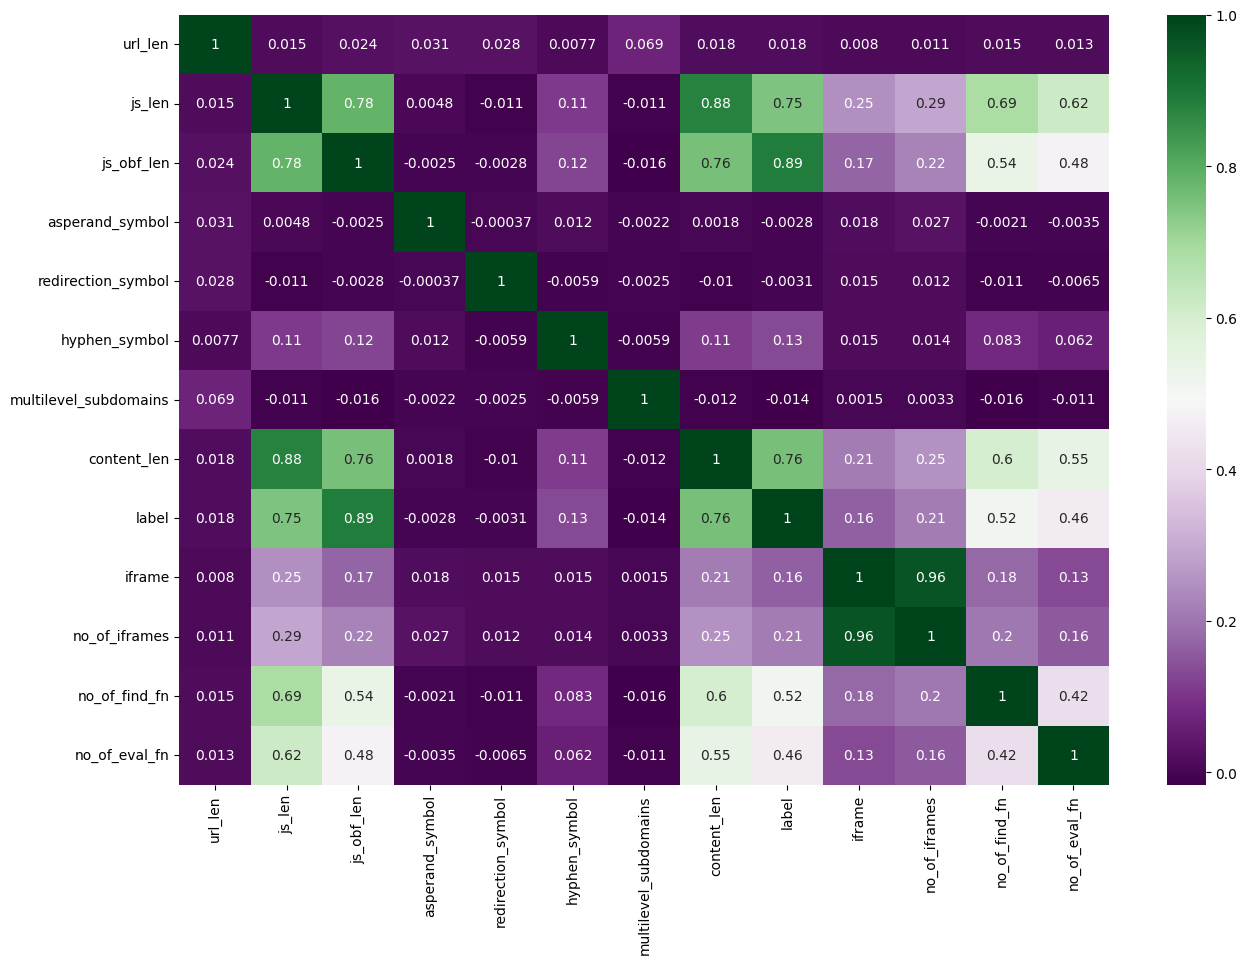

In [72]:
# Heatmap of correlation of numerical columns and engineered features from url and content features
plt.figure(figsize=(15,10))
sns.heatmap(train.corr(), annot = True,cmap= "PRGn")
plt.show()

***js_len, content_url are highly correlated with label.***<br>
***js_obf_len is very highly correlated with label.***<br> 
***no_of_eval_fn, no_of_find_fn also show some correlation with label, albeit very lightly.*** 


In [73]:
# Dropping columns with unique values
train.drop(['url', 'ip_add', 'content'],axis=1, inplace =True)

In [74]:
# One hot encoding columns using DictVectorizer
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer(sparse=False)
train_dict = train.to_dict(orient='records')
train_dv = dv.fit_transform(train_dict)
train_cols_dv = list(dv.get_feature_names_out())

In [75]:
train_engineered = pd.DataFrame(data=train_dv, columns=train_cols_dv)

In [76]:
train_engineered.head()

asperand_symbol  content_len  geo_loc=Albania  geo_loc=Algeria  \
0              0.0       1513.0              0.0              0.0   
1              0.0       2103.0              0.0              0.0   
2              0.0       2544.0              0.0              0.0   
3              0.0        786.0              0.0              0.0   
4              0.0       1918.0              0.0              0.0   

   geo_loc=Andorra  geo_loc=Angola  geo_loc=Anguilla  geo_loc=Argentina  \
0              0.0             0.0               0.0                0.0   
1              0.0             0.0               0.0                0.0   
2              0.0             0.0               0.0                0.0   
3              0.0             0.0               0.0                0.0   
4              0.0             0.0               0.0                0.0   

   geo_loc=Armenia  geo_loc=Australia  geo_loc=Austria  geo_loc=Azerbaijan  \
0              0.0                0.0              0.0                 0.0   
1              0.0                0.0              0.0                 0.0   
2              0.0                0.0              0.0                 0.0   
3              0.0                0.0              0.0                 0.0   
4              0.0                0.0              0.0                 0.0   

   geo_loc=Bahrain  geo_loc=Bangladesh  geo_loc=Barbados  geo_loc=Belarus  \
0              0.0                 0.0               0.0              0.0   
1              0.0                 0.0               0.0              0.0   
2              0.0                 0.0               0.0              0.0   
3              0.0                 0.0               0.0              0.0   
4              0.0                 0.0               0.0              0.0   

   geo_loc=Belgium  geo_loc=Belize  geo_loc=Bolivia  \
0              0.0             0.0              0.0   
1              0.0             0.0              0.0   
2              0.0             0.0              0.0   
3              0.0             0.0              0.0   
4              0.0             0.0              0.0   

   geo_loc=Bosnia and Herzegovina  geo_loc=Brazil  \
0                             0.0             0.0   
1                             0.0             0.0   
2                             0.0             0.0   
3                             0.0             0.0   
4                             0.0             0.0   

   geo_loc=British Virgin Islands  geo_loc=Bulgaria  geo_loc=Cambodia  \
0                             0.0               0.0               0.0   
1                             0.0               0.0               0.0   
2                             0.0               0.0               0.0   
3                             0.0               0.0               0.0   
4                             0.0               0.0               0.0   

   geo_loc=Canada  geo_loc=Cayman Islands  geo_loc=Chile  geo_loc=China  \
0             0.0                     0.0            0.0            0.0   
1             0.0                     0.0            0.0            1.0   
2             0.0                     0.0            0.0            0.0   
3             0.0                     0.0            0.0            0.0   
4             0.0                     0.0            0.0            0.0   

   geo_loc=Colombia  geo_loc=Costa Rica  geo_loc=Croatia  geo_loc=Cuba  \
0               0.0                 0.0              0.0           0.0   
1               0.0                 0.0              0.0           0.0   
2               0.0                 0.0              0.0           0.0   
3               0.0                 0.0              0.0           0.0   
4               0.0                 0.0              0.0           0.0   

   geo_loc=Cyprus  geo_loc=Czechia  geo_loc=Denmark  \
0             0.0              1.0              0.0   
1             0.0              0.0              0.0   
2             0.0              0.0              0.0   


## Train Test Split

In [77]:
X = train_engineered.drop('label', axis=1)
y = train_engineered['label']

In [78]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(X,y,test_size=0.20, random_state=100, stratify=y)

In [79]:
x_train.shape, y_train.shape

((9600, 353), (9600,))

In [80]:
x_val.shape, y_val.shape

((2400, 353), (2400,))

# Balancing Imbalanced Dataset using SMOTE

In [81]:
from imblearn.over_sampling import SMOTE
SMOTE = SMOTE()

# fit and apply the transform
x_train_SMOTE, y_train_SMOTE = SMOTE.fit_resample(x_train, y_train)

In [82]:
from collections import Counter
print("Before oversampling: ",Counter(y_train))
print("After oversampling: ",Counter(y_train_SMOTE))

Before oversampling:  Counter({0.0: 9377, 1.0: 223})
After oversampling:  Counter({0.0: 9377, 1.0: 9377})


# Modeling

 ## Base Line Model

In [83]:
from sklearn import metrics

In [84]:
log_reg = LogisticRegression()
model_lr = log_reg.fit(x_train_SMOTE, y_train_SMOTE)

y_val_pred = model_lr.predict(x_val)

y_val_pred_prob = model_lr.predict_proba(x_val)

# Generate model evaluation metrics for the Logistic Regression
print("Performance metrics of the model for the Logistic Regression")
print("-"*100)
print("Accuracy: ", metrics.accuracy_score(y_val, y_val_pred))
print("Balanced Accuracy: ", metrics.balanced_accuracy_score(y_val, y_val_pred))

print("Precision Score: ",metrics.precision_score(y_val, y_val_pred))
print("Recall Score: ",metrics.recall_score(y_val, y_val_pred))
print("AUROC Score: ",metrics.roc_auc_score(y_val, y_val_pred_prob[:,1]))
print()
print("Confusion Matrix:  \n ",metrics.confusion_matrix(y_val, y_val_pred))
print()
print("Classification Report:\n ",metrics.classification_report(y_val, y_val_pred))

Performance metrics of the model for the Logistic Regression
----------------------------------------------------------------------------------------------------
Accuracy:  0.9908333333333333
Balanced Accuracy:  0.995307167235495
Precision Score:  0.717948717948718
Recall Score:  1.0
AUROC Score:  0.9999695270599708

Confusion Matrix:  
  [[2322   22]
 [   0   56]]

Classification Report:
                precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      2344
         1.0       0.72      1.00      0.84        56

    accuracy                           0.99      2400
   macro avg       0.86      1.00      0.92      2400
weighted avg       0.99      0.99      0.99      2400



In [85]:
# Other Classifiers along with the baseline model
classifiers = [
            ("Logistic Regression - ", LogisticRegression()),
            ("K-Nearest Neighbors - ",  KNeighborsClassifier(2)),
            ("Decision Tree - ",  DecisionTreeClassifier(max_depth=5)),
            ("Random Forest - ",  RandomForestClassifier(n_estimators=100)),
            ("AdaBoost - ",  AdaBoostClassifier(n_estimators=100)),
            ("XGBoost - ", XGBClassifier(n_estimators=100,objective='binary:logistic'))]


In [86]:
# Generate model evaluation metrics
print("Base Models")
print('-'*60)
accuracy_base = []
balanced_accuracy_base = []
precision_base =[]
recall_base = []
f1_base = []
model_names = [i[0] for i in classifiers]
for clf in classifiers:
    clf[1].fit(x_train_SMOTE, y_train_SMOTE)
    y_val_pred= clf[1].predict(x_val)
    y_val_pred_prob= clf[1].predict_proba(x_val)

    accuracy_base.append(metrics.accuracy_score(y_val, y_val_pred))
    balanced_accuracy_base.append(metrics.accuracy_score(y_val, y_val_pred))
    precision_base.append(metrics.precision_score(y_val, y_val_pred))
    recall_base.append(metrics.recall_score(y_val, y_val_pred))
    f1_base.append(metrics.recall_score(y_val, y_val_pred))
    
    print(clf[0],
          "\n\t Accuracy: ",                metrics.accuracy_score(y_val, y_val_pred),
          "\n\t Balanced Accuracy: ",       metrics.balanced_accuracy_score(y_val, y_val_pred),
          "\n\t Precision Score: ",         metrics.precision_score(y_val, y_val_pred),
          "\n\t Recall Score: ",            metrics.recall_score(y_val, y_val_pred),
          "\n\t f1 Score: ",                metrics.f1_score(y_val, y_val_pred),
          "\n\t AUROC Score: ",             metrics.roc_auc_score(y_val, y_val_pred_prob[:,1]),
          "\n\t Confusion Matrix:  \n ",    metrics.confusion_matrix(y_val, y_val_pred),
          "\n\t Classification Report:\n ", metrics.classification_report(y_val, y_val_pred),"\n"
          )

Base Models
------------------------------------------------------------
Logistic Regression -  
	 Accuracy:  0.9908333333333333 
	 Balanced Accuracy:  0.995307167235495 
	 Precision Score:  0.717948717948718 
	 Recall Score:  1.0 
	 f1 Score:  0.835820895522388 
	 AUROC Score:  0.9999695270599708 
	 Confusion Matrix:  
  [[2322   22]
 [   0   56]] 
	 Classification Report:
                precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      2344
         1.0       0.72      1.00      0.84        56

    accuracy                           0.99      2400
   macro avg       0.86      1.00      0.92      2400
weighted avg       0.99      0.99      0.99      2400
 

K-Nearest Neighbors -  
	 Accuracy:  0.9975 
	 Balanced Accuracy:  0.9987201365187713 
	 Precision Score:  0.9032258064516129 
	 Recall Score:  1.0 
	 f1 Score:  0.9491525423728813 
	 AUROC Score:  0.9987201365187713 
	 Confusion Matrix:  
  [[2338    6]
 [   0   56]] 
	 Classification Repor

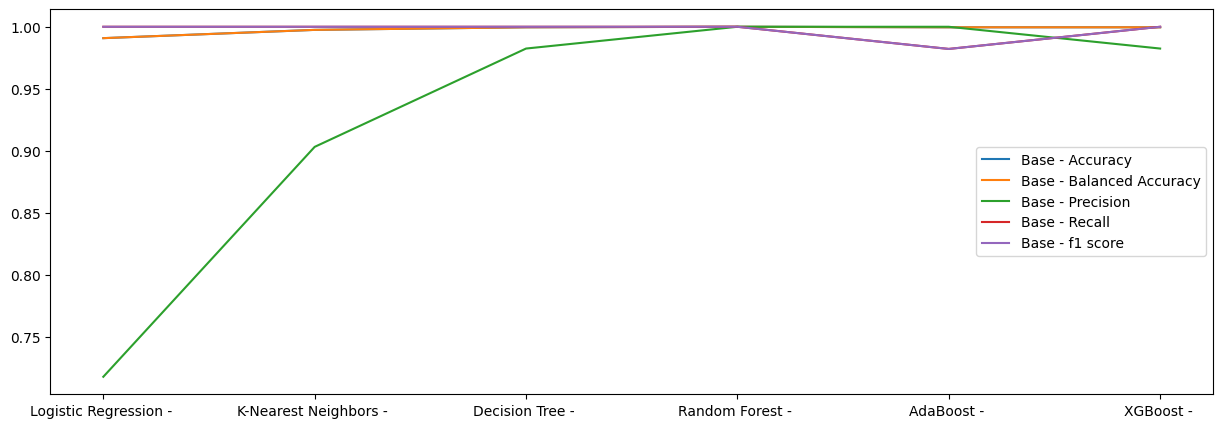

In [87]:
# Plotting the classification metrics for all the base models
plt.figure(figsize=(15,5))
plt.plot(model_names , accuracy_base, label = "Base - Accuracy")
plt.plot(model_names , balanced_accuracy_base, label = "Base - Balanced Accuracy")
plt.plot(model_names , precision_base, label = "Base - Precision")
plt.plot(model_names , recall_base, label = "Base - Recall")
plt.plot(model_names , f1_base, label = "Base - f1 score")

plt.legend(loc="right")
plt.show()


## Feature Selection through models

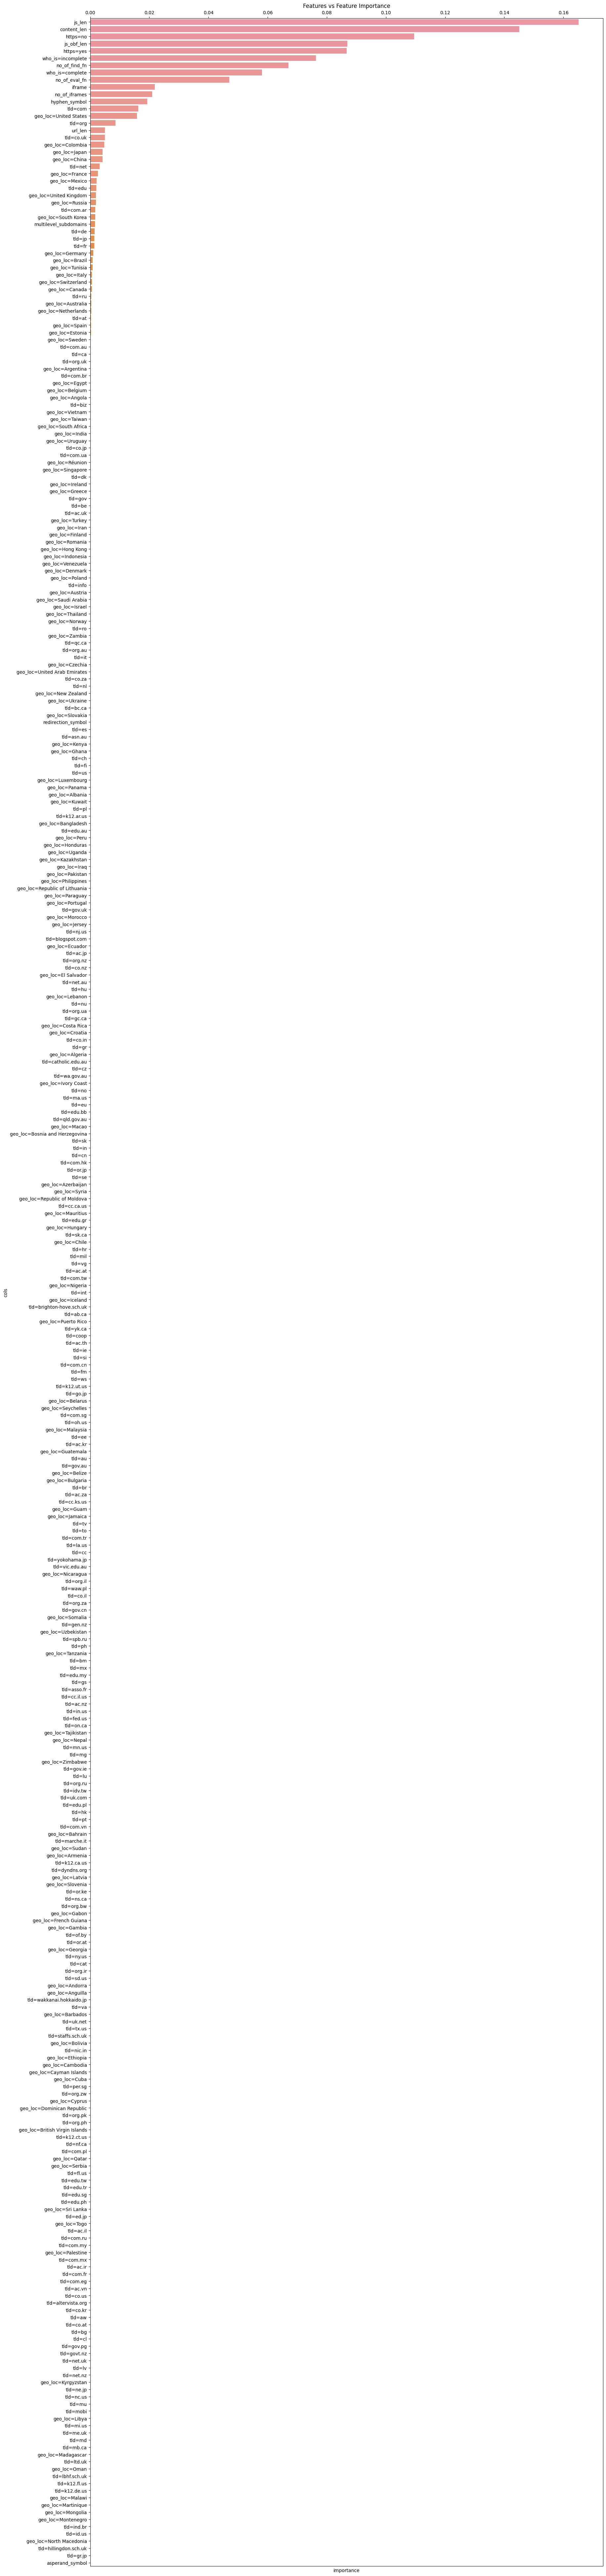

In [88]:
rndf = RandomForestClassifier(n_estimators=150)
rndf.fit(x_train_SMOTE, y_train_SMOTE)
importance = pd.DataFrame.from_dict({'cols':x_train.columns, 'importance': rndf.feature_importances_})
importance = importance.sort_values(by='importance', ascending=False)
plt.figure(figsize=(20,100))
sns.barplot(y=importance.cols, x=importance.importance)
plt.title("Features vs Feature Importance")
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = True, labeltop=True)
plt.show()

In [89]:
imp_cols = importance[importance.importance >= 0.005].cols.values
imp_cols

array(['js_len', 'content_len', 'https=no', 'js_obf_len', 'https=yes',
       'who_is=incomplete', 'no_of_find_fn', 'who_is=complete',
       'no_of_eval_fn', 'iframe', 'no_of_iframes', 'hyphen_symbol',
       'tld=com', 'geo_loc=United States', 'tld=org'], dtype=object)

In [90]:
# Generate model evaluation metrics
print("Models generated with features having feature importances threshold >= 0.005")
print("Base Models")
print('-'*60)
accuracy_thresh_005= []
balanced_accuracy_thresh_005 = []
precision_thresh_005 =[]
recall_thresh_005 = []
f1_thresh_005 = []

model_names = [i[0] for i in classifiers]

for clf in classifiers:
    clf[1].fit(x_train_SMOTE[imp_cols], y_train_SMOTE)
    y_val_pred= clf[1].predict(x_val[imp_cols])
    y_val_pred_prob= clf[1].predict_proba(x_val[imp_cols])
    
    accuracy_thresh_005.append(metrics.accuracy_score(y_val, y_val_pred))
    balanced_accuracy_thresh_005.append(metrics.accuracy_score(y_val, y_val_pred))
    precision_thresh_005.append(metrics.precision_score(y_val, y_val_pred))
    recall_thresh_005.append(metrics.recall_score(y_val, y_val_pred))
    f1_thresh_005.append(metrics.recall_score(y_val, y_val_pred))
    
    print(clf[0],
          "\n\t Accuracy: ",                metrics.accuracy_score(y_val, y_val_pred),
          "\n\t Balanced Accuracy: ",       metrics.balanced_accuracy_score(y_val, y_val_pred),
          "\n\t Precision Score: ",         metrics.precision_score(y_val, y_val_pred),
          "\n\t Recall Score: ",            metrics.recall_score(y_val, y_val_pred),
          "\n\t f1 Score: ",                metrics.f1_score(y_val, y_val_pred),
          "\n\t AUROC Score: ",             metrics.roc_auc_score(y_val, y_val_pred_prob[:,1]),
          "\n\t Confusion Matrix:  \n ",    metrics.confusion_matrix(y_val, y_val_pred),
          "\n\t Classification Report:\n ", metrics.classification_report(y_val, y_val_pred),"\n"
          )

Models generated with features having feature importances threshold >= 0.005
Base Models
------------------------------------------------------------
Logistic Regression -  
	 Accuracy:  0.9908333333333333 
	 Balanced Accuracy:  0.995307167235495 
	 Precision Score:  0.717948717948718 
	 Recall Score:  1.0 
	 f1 Score:  0.835820895522388 
	 AUROC Score:  0.999977145294978 
	 Confusion Matrix:  
  [[2322   22]
 [   0   56]] 
	 Classification Report:
                precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      2344
         1.0       0.72      1.00      0.84        56

    accuracy                           0.99      2400
   macro avg       0.86      1.00      0.92      2400
weighted avg       0.99      0.99      0.99      2400
 

K-Nearest Neighbors -  
	 Accuracy:  0.9975 
	 Balanced Accuracy:  0.9987201365187713 
	 Precision Score:  0.9032258064516129 
	 Recall Score:  1.0 
	 f1 Score:  0.9491525423728813 
	 AUROC Score:  0.9987201365187713

**Clearly there is improvement but it is only marginal**

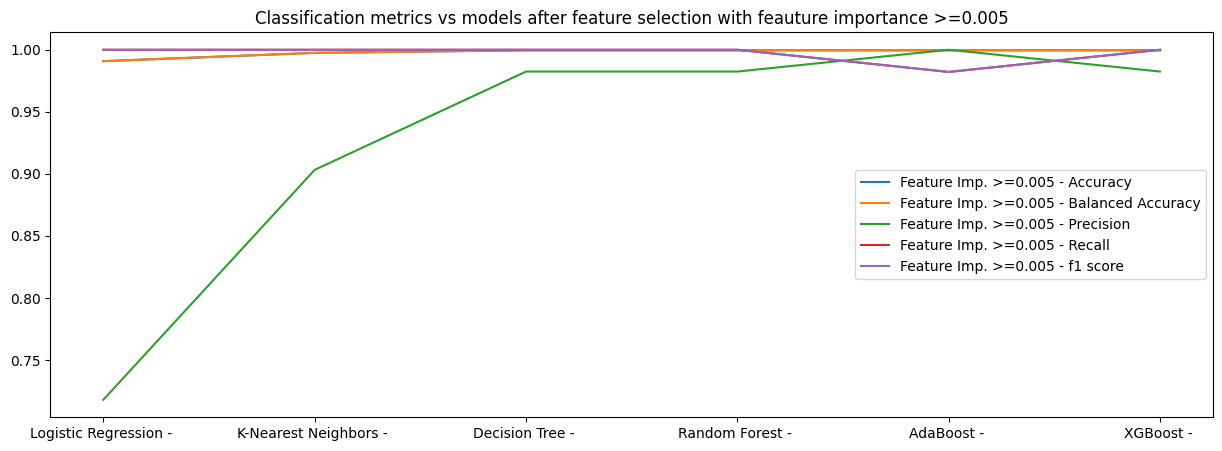

In [91]:
# Plotting the classification metrics for all the models generated from features which have feature importance >=0.03
plt.figure(figsize=(15,5))
plt.plot(model_names , accuracy_thresh_005, label = "Feature Imp. >=0.005 - Accuracy")
plt.plot(model_names , balanced_accuracy_thresh_005, label = "Feature Imp. >=0.005 - Balanced Accuracy")
plt.plot(model_names , precision_thresh_005, label = "Feature Imp. >=0.005 - Precision")
plt.plot(model_names , recall_thresh_005, label = "Feature Imp. >=0.005 - Recall")
plt.plot(model_names , f1_thresh_005, label = "Feature Imp. >=0.005 - f1 score")
plt.title("Classification metrics vs models after feature selection with feauture importance >=0.005")
plt.legend(loc="right")
plt.show()


### Classification metrics of base models vs models after feature selection

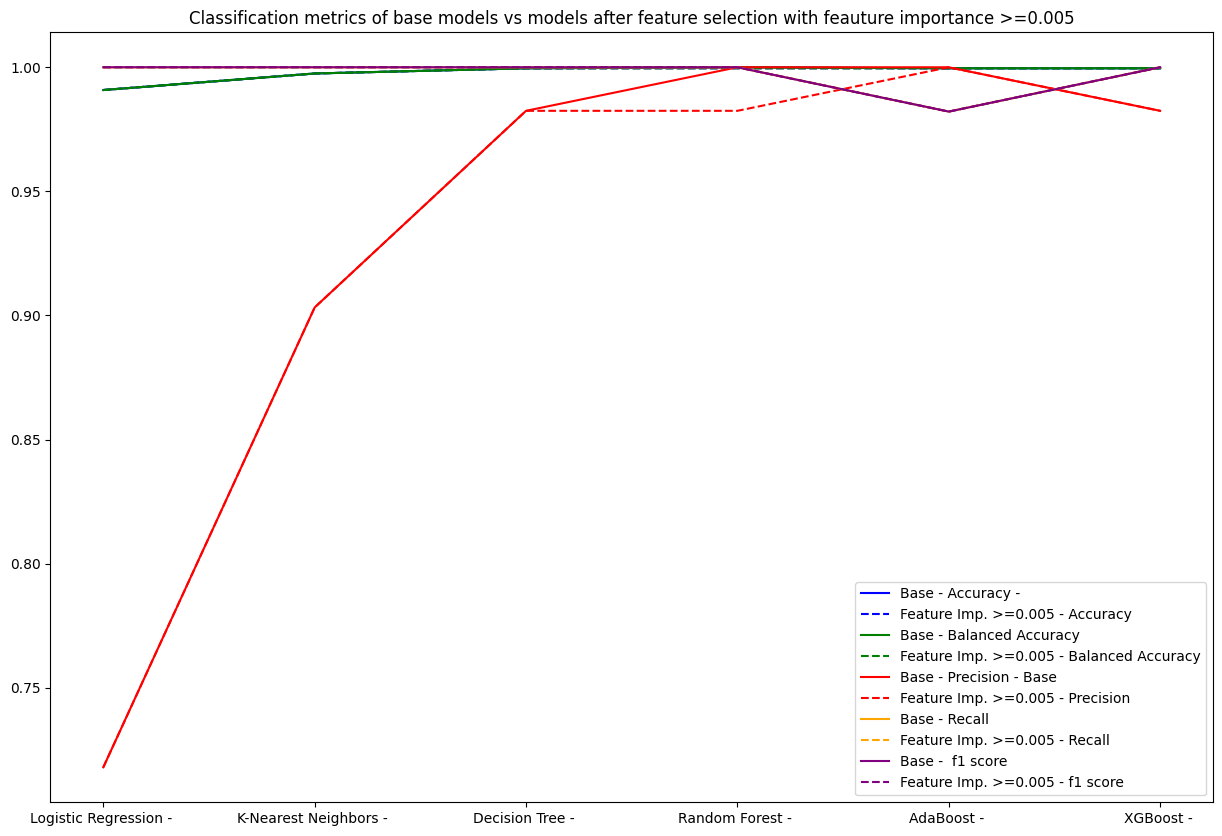

In [92]:
# Plotting the classification metrics for all the base models and models generated from features which have feature importance >=0.03

plt.figure(figsize=(15,10))
plt.plot(model_names , accuracy_base, label = "Base - Accuracy - ",c = 'blue')
plt.plot(model_names , accuracy_thresh_005, label = "Feature Imp. >=0.005 - Accuracy", c = 'blue', linestyle='dashed')

plt.plot(model_names , balanced_accuracy_base, label = "Base - Balanced Accuracy", c = 'green')
plt.plot(model_names , balanced_accuracy_thresh_005, label = "Feature Imp. >=0.005 - Balanced Accuracy", c = 'green', linestyle='dashed')

plt.plot(model_names , precision_base, label = "Base - Precision - Base",c = 'red')
plt.plot(model_names , precision_thresh_005, label = "Feature Imp. >=0.005 - Precision", c = 'red', linestyle='dashed')
 
plt.plot(model_names , recall_base, label = "Base - Recall",c = 'orange')
plt.plot(model_names , recall_thresh_005, label = "Feature Imp. >=0.005 - Recall", c = 'orange', linestyle='dashed')

plt.plot(model_names , recall_base, label = "Base -  f1 score",c = 'purple')
plt.plot(model_names , f1_thresh_005, label = "Feature Imp. >=0.005 - f1 score", c = 'purple', linestyle='dashed')

plt.title("Classification metrics of base models vs models after feature selection with feauture importance >=0.005")

plt.legend()
plt.show()
 


# Cross-validation using K-Fold cross-validation to check model robustness

### Balanced Accuracy for scoring

In [93]:
scoring = 'balanced_accuracy'
balanced_accuracy_scoring_results=[]
names=[]
for classifier_name, model in classifiers:
    kfold = KFold(n_splits=10, random_state=100, shuffle=True)
    cv_results = cross_val_score(model, x_train_SMOTE[imp_cols], y_train_SMOTE, cv=kfold, scoring=scoring)
    balanced_accuracy_scoring_results.append(cv_results)
    names.append(classifier_name)
    print(classifier_name,
                      "\n\t CV-Mean:", cv_results.mean(),
                    "\n\t CV-Std. Dev:",  cv_results.std(),"\n")

Logistic Regression -  
	 CV-Mean: 0.992473932856939 
	 CV-Std. Dev: 0.0015361216331356352 

K-Nearest Neighbors -  
	 CV-Mean: 0.9949931281988953 
	 CV-Std. Dev: 0.0014848719134768023 

Decision Tree -  
	 CV-Mean: 0.9985115560910556 
	 CV-Std. Dev: 0.0011962825148030206 

Random Forest -  
	 CV-Mean: 0.9998942906916586 
	 CV-Std. Dev: 0.0002114199455519129 

AdaBoost -  
	 CV-Mean: 0.9997869927779839 
	 CV-Std. Dev: 0.0003534996315698638 

XGBoost -  
	 CV-Mean: 0.9996272000749533 
	 CV-Std. Dev: 0.0004163484572954469 



### f1 score for scoring

In [94]:
scoring = 'f1'
f1_scoring_results=[]
names=[]
for classifier_name, model in classifiers:
    kfold = KFold(n_splits=10, random_state=100, shuffle=True)
    cv_results = cross_val_score(model, x_train_SMOTE[imp_cols], y_train_SMOTE, cv=kfold, scoring=scoring)
    f1_scoring_results.append(cv_results)
    names.append(classifier_name)
    print(classifier_name,
                      "\n\t CV-Mean:", cv_results.mean(),
                    "\n\t CV-Std. Dev:",  cv_results.std(),"\n")

Logistic Regression -  
	 CV-Mean: 0.9924924115466405 
	 CV-Std. Dev: 0.0015297271760106618 

K-Nearest Neighbors -  
	 CV-Mean: 0.9949764530407796 
	 CV-Std. Dev: 0.0014885772473928662 

Decision Tree -  
	 CV-Mean: 0.9985137089960945 
	 CV-Std. Dev: 0.001189096755034779 

Random Forest -  
	 CV-Mean: 0.9998942347892597 
	 CV-Std. Dev: 0.00021153175245892448 

AdaBoost -  
	 CV-Mean: 0.9997881310367213 
	 CV-Std. Dev: 0.0003506718919974707 

XGBoost -  
	 CV-Mean: 0.9996306990665857 
	 CV-Std. Dev: 0.00041057600876407606 



### Saving the mean and standard deviation scores of kfold cross-validation into variables

In [95]:
cv_ba_scoring_mean = [cv.mean() for cv in balanced_accuracy_scoring_results]
cv_ba_scoring_std = [cv.std() for cv in balanced_accuracy_scoring_results]

In [96]:
cv_f1_scoring_mean = [cv.mean() for cv in f1_scoring_results]
cv_f1_scoring_std = [cv.std() for cv in f1_scoring_results]


### Plot of cross-validation means of models using Balanced Accuracy and f1 score for scoring 

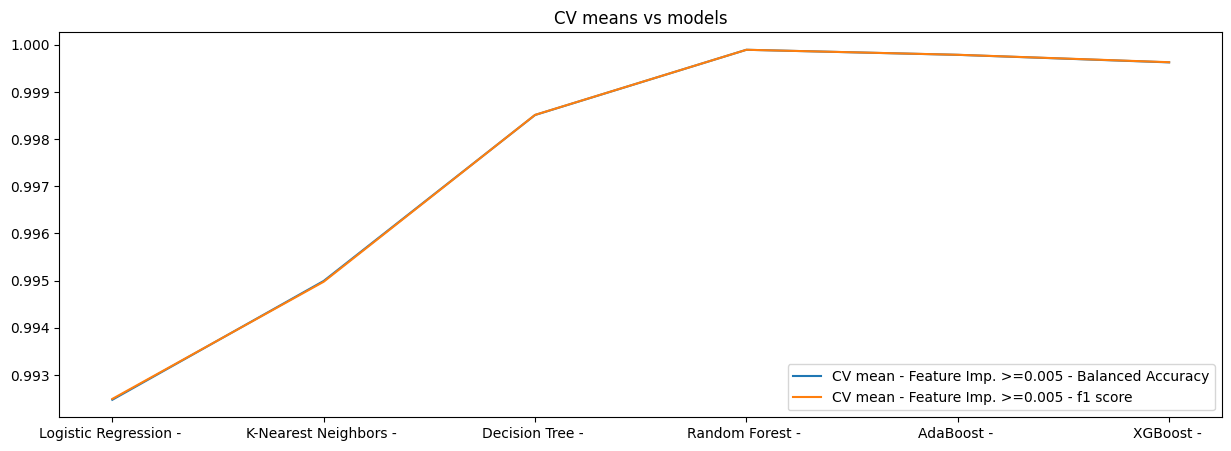

In [97]:
plt.figure(figsize=(15,5))
plt.plot(names, cv_ba_scoring_mean, label = "CV mean - Feature Imp. >=0.005 - Balanced Accuracy")
plt.plot(names, cv_f1_scoring_mean, label = "CV mean - Feature Imp. >=0.005 - f1 score")
plt.title("CV means vs models")
plt.legend(loc="lower right")
plt.show()

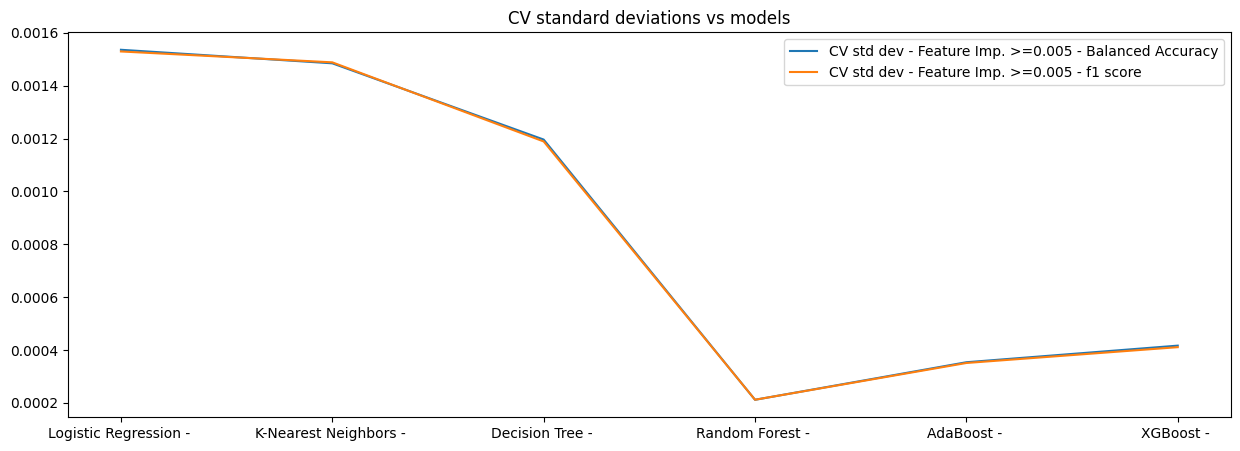

In [98]:
plt.figure(figsize=(15,5))

plt.plot(names, cv_ba_scoring_std, label = "CV std dev - Feature Imp. >=0.005 - Balanced Accuracy")
plt.plot(names, cv_f1_scoring_std, label = "CV std dev - Feature Imp. >=0.005 - f1 score")

plt.title("CV standard deviations vs models")
plt.legend(loc="upper right")
plt.show()

In [99]:
metrics_and_cv = pd.DataFrame(data={"model_name": names,
                                    "accuracy": accuracy_thresh_005,
                                    "balanced_accuracy": balanced_accuracy_thresh_005,
                                    "precision": precision_thresh_005,
                                    "recall": recall_thresh_005,
                                    "f1_score": f1_thresh_005,
                                    "ba_cv_mean": cv_ba_scoring_mean,
                                    "ba_cv_std": cv_ba_scoring_std,
                                    "f1_cv_mean": cv_f1_scoring_mean,
                                    "f1_cv_std": cv_f1_scoring_std
                                   })

In [100]:
metrics_and_cv

model_name  accuracy  balanced_accuracy  precision    recall  \
0  Logistic Regression -   0.990833           0.990833   0.717949  1.000000   
1  K-Nearest Neighbors -   0.997500           0.997500   0.903226  1.000000   
2        Decision Tree -   0.999583           0.999583   0.982456  1.000000   
3        Random Forest -   0.999583           0.999583   0.982456  1.000000   
4             AdaBoost -   0.999583           0.999583   1.000000  0.982143   
5              XGBoost -   0.999583           0.999583   0.982456  1.000000   

   f1_score  ba_cv_mean  ba_cv_std  f1_cv_mean  f1_cv_std  
0  1.000000    0.992474   0.001536    0.992492   0.001530  
1  1.000000    0.994993   0.001485    0.994976   0.001489  
2  1.000000    0.998512   0.001196    0.998514   0.001189  
3  1.000000    0.999894   0.000211    0.999894   0.000212  
4  0.982143    0.999787   0.000353    0.999788   0.000351  
5  1.000000    0.999627   0.000416    0.999631   0.000411

In [101]:
metrics_and_cv.columns

Index(['model_name', 'accuracy', 'balanced_accuracy', 'precision', 'recall',
       'f1_score', 'ba_cv_mean', 'ba_cv_std', 'f1_cv_mean', 'f1_cv_std'],
      dtype='object')

In [102]:
metrics_and_cv[['model_name', 'accuracy', 'balanced_accuracy', 
                 'precision', 'recall', 'f1_score']].nlargest(4, ['accuracy', 'balanced_accuracy', 'precision', 
                                                                  'recall', 'f1_score'])

model_name  accuracy  balanced_accuracy  precision    recall  \
4       AdaBoost -   0.999583           0.999583   1.000000  0.982143   
2  Decision Tree -   0.999583           0.999583   0.982456  1.000000   
3  Random Forest -   0.999583           0.999583   0.982456  1.000000   
5        XGBoost -   0.999583           0.999583   0.982456  1.000000   

   f1_score  
4  0.982143  
2  1.000000  
3  1.000000  
5  1.000000

In [103]:
metrics_and_cv[['model_name','ba_cv_mean', 'ba_cv_std', 
                'f1_cv_mean', 'f1_cv_std']].nlargest(3, ['ba_cv_mean', 'f1_cv_mean'])

model_name  ba_cv_mean  ba_cv_std  f1_cv_mean  f1_cv_std
3  Random Forest -     0.999894   0.000211    0.999894   0.000212
4       AdaBoost -     0.999787   0.000353    0.999788   0.000351
5        XGBoost -     0.999627   0.000416    0.999631   0.000411

In [104]:
metrics_and_cv[['model_name','ba_cv_mean', 'ba_cv_std', 
                'f1_cv_mean', 'f1_cv_std']].nsmallest(3, ['ba_cv_std',  'f1_cv_std'])

model_name  ba_cv_mean  ba_cv_std  f1_cv_mean  f1_cv_std
3  Random Forest -     0.999894   0.000211    0.999894   0.000212
4       AdaBoost -     0.999787   0.000353    0.999788   0.000351
5        XGBoost -     0.999627   0.000416    0.999631   0.000411

**From the above the 3 plots, we can see, model based feature selection with feature importance >=0.005 yields better results with respect to accuracy, balanced_accuracy, f1 score, precision and recall.**

**However, when selecting a model we have to make sure the model is robust in addition considering the above metrics.

**Best Models according to metrics:**
- Random Forest  
- AdaBoost 
- XGBoost

***Most Robust Models:***
- AdaBoost 
- Random Forest 
- XGBoost

***Therefore, it makes sense to choose the following models for hyper-tuning***
- Adaboost
- Random Forest 
- XGBoost

 

# Tune Model for better Performance

In [105]:
ht_models = [] # For saving the hypertuned-model names and models 

## Random Forest

In [106]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [107]:
param_grid = {'criterion':['gini','entropy','cross_entropy'],
              'max_depth':[2, 3, 4, 5, 6, 7, 8, 9],
              'random_state':[100],
              'n_estimators':[200,400,600],
              'n_jobs':[-1], 
              'random_state':[100],
                'verbose': [0]}

RF_grid = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv = 5, scoring='balanced_accuracy', verbose=1)

In [108]:
RF_grid.fit(x_train_SMOTE[imp_cols], y_train_SMOTE)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'cross_entropy'],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
                         'n_estimators': [200, 400, 600], 'n_jobs': [-1],
                         'random_state': [100], 'verbose': [0]},
             scoring='balanced_accuracy', verbose=1)

In [109]:
RF_grid.best_params_

{'criterion': 'entropy',
 'max_depth': 9,
 'n_estimators': 400,
 'n_jobs': -1,
 'random_state': 100,
 'verbose': 0}

In [110]:
ht_models.append(("HT RandomForest Classifier", RF_grid.best_estimator_))

## Adaboost

In [111]:
AdaBoostClassifier().get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': None}

In [112]:
param_grid = {'algorithm':['SAMME.R'],
              'learning_rate':[0.1, 0.2, 0.3],
              'n_estimators':[200,400,600],
              'random_state':[100]}

AB_grid = GridSearchCV(AdaBoostClassifier(), param_grid=param_grid, cv = 5, scoring='balanced_accuracy', verbose=1)

In [113]:
AB_grid.fit(x_train_SMOTE[imp_cols], y_train_SMOTE)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=AdaBoostClassifier(),
             param_grid={'algorithm': ['SAMME.R'],
                         'learning_rate': [0.1, 0.2, 0.3],
                         'n_estimators': [200, 400, 600],
                         'random_state': [100]},
             scoring='balanced_accuracy', verbose=1)

In [114]:
AB_grid.best_params_

{'algorithm': 'SAMME.R',
 'learning_rate': 0.2,
 'n_estimators': 200,
 'random_state': 100}

In [115]:
ht_models.append(("HT Adaboost Classifier", AB_grid.best_estimator_))

## XGBoost

In [116]:
XGBClassifier().get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [117]:
param_grid = {
              'colsample_bylevel':[0.8],
              'colsample_bytree':[0.8],
              'learning_rate':[0.1, 0,2, 0.3],
              'max_depth':[4, 7],
              'min_child_weight':[1, 3], 
              'n_estimators':[200, 400, 600],
              'n_jobs':[-1], 
              'objective':['binary:logistic'],
              'random_state':[100],
              'reg_alpha':[0.1, 1 ], 
              'scale_pos_weight':[1]
            }

XGB_grid = GridSearchCV(XGBClassifier(), param_grid=param_grid,cv = 5, scoring='balanced_accuracy', verbose=1)

In [118]:
XGB_grid.fit(x_train_SMOTE[imp_cols], y_train_SMOTE)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'colsample_bylevel': [0.8], 'colsample_bytree': [0.8],
                         'learning_rate': [0.1, 0, 2, 0.3], 'max_depth': [4, 7],
                         'min_child_weight': [1, 3],
                         'n_estimators': [200, 400, 600], 'n_jobs': [-1],
                         'objective': ['binary:logistic'],
                         'random_state': [100], 'reg_alpha': [0.1, 1],
                         'scale_pos_weight': [1]},
             scoring='balanced_accuracy', verbose=1)

In [119]:
XGB_grid.best_params_

{'colsample_bylevel': 0.8,
 'colsample_bytree': 0.8,
 'learning_rate': 0.3,
 'max_depth': 7,
 'min_child_weight': 1,
 'n_estimators': 400,
 'n_jobs': -1,
 'objective': 'binary:logistic',
 'random_state': 100,
 'reg_alpha': 0.1,
 'scale_pos_weight': 1}

In [120]:
ht_models.append(("HT XGB Classifier", XGB_grid.best_estimator_))

## Generate performance metrics

In [121]:
ht_accuracy= []
ht_balanced_accuracy = []
ht_precision =[]
ht_recall = []
ht_f1 = []

ht_model_names = [i[0] for i in ht_models]

for clf in ht_models:
    clf[1].fit(x_train_SMOTE[imp_cols], y_train_SMOTE)
    y_val_pred= clf[1].predict(x_val[imp_cols])
    y_val_pred_prob= clf[1].predict_proba(x_val[imp_cols])
    
    ht_accuracy.append(metrics.accuracy_score(y_val, y_val_pred))
    ht_balanced_accuracy.append(metrics.accuracy_score(y_val, y_val_pred))
    ht_precision.append(metrics.precision_score(y_val, y_val_pred))
    ht_recall.append(metrics.recall_score(y_val, y_val_pred))
    ht_f1.append(metrics.recall_score(y_val, y_val_pred))
    
    print(clf[0],
      "\n\t Accuracy: ",                metrics.accuracy_score(y_val, y_val_pred),
      "\n\t Balanced Accuracy: ",       metrics.balanced_accuracy_score(y_val, y_val_pred),
      "\n\t Precision Score: ",         metrics.precision_score(y_val, y_val_pred),
      "\n\t Recall Score: ",            metrics.recall_score(y_val, y_val_pred),
      "\n\t f1 Score: ",                metrics.f1_score(y_val, y_val_pred),
      "\n\t AUROC Score: ",             metrics.roc_auc_score(y_val, y_val_pred_prob[:,1]),
      "\n\t Confusion Matrix:  \n ",    metrics.confusion_matrix(y_val, y_val_pred),
      "\n\t Classification Report:\n ", metrics.classification_report(y_val, y_val_pred),"\n"
      )

HT RandomForest Classifier 
	 Accuracy:  1.0 
	 Balanced Accuracy:  1.0 
	 Precision Score:  1.0 
	 Recall Score:  1.0 
	 f1 Score:  1.0 
	 AUROC Score:  0.9999999999999999 
	 Confusion Matrix:  
  [[2344    0]
 [   0   56]] 
	 Classification Report:
                precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2344
         1.0       1.00      1.00      1.00        56

    accuracy                           1.00      2400
   macro avg       1.00      1.00      1.00      2400
weighted avg       1.00      1.00      1.00      2400
 

HT Adaboost Classifier 
	 Accuracy:  0.99875 
	 Balanced Accuracy:  0.990644807411019 
	 Precision Score:  0.9649122807017544 
	 Recall Score:  0.9821428571428571 
	 f1 Score:  0.9734513274336283 
	 AUROC Score:  0.9999847635299853 
	 Confusion Matrix:  
  [[2342    2]
 [   1   55]] 
	 Classification Report:
                precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      23

### Plot the classification metrics for hypertuned models  

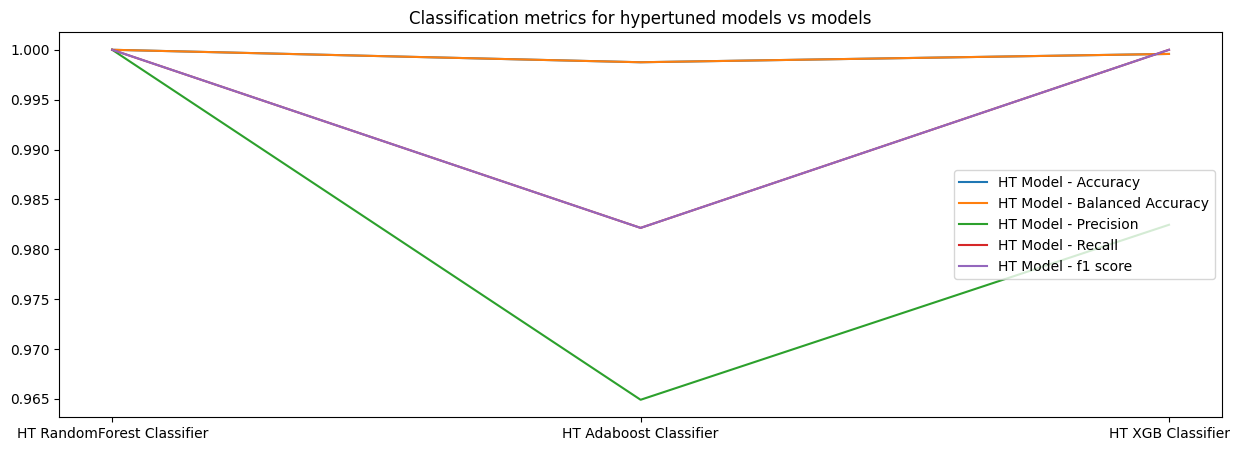

In [122]:
## Plotting the classification metrics for hypertuned models generated from features which have feature importance >=0.03
plt.figure(figsize=(15,5))
plt.plot(ht_model_names , ht_accuracy, label = "HT Model - Accuracy")
plt.plot(ht_model_names , ht_balanced_accuracy, label = "HT Model - Balanced Accuracy")
plt.plot(ht_model_names , ht_precision, label = "HT Model - Precision")
plt.plot(ht_model_names , ht_recall, label = "HT Model - Recall")
plt.plot(ht_model_names , ht_f1, label = "HT Model - f1 score")
 
plt.title("Classification metrics for hypertuned models vs models")
plt.legend(loc="right")
plt.show()


***Since the models are being cross-validated when they're hypertuned, we need not cross-validate them again***

# Final Model

In [131]:
final_model = ht_models[ht_model_names.index("HT RandomForest Classifier")][1]
final_model

RandomForestClassifier(criterion='entropy', max_depth=9, n_estimators=400,
                       n_jobs=-1, random_state=100)

# Predict

In [124]:
def predict(df):

    df['label']=np.where(df['label']=='bad', 1, 0) # bad=1 and good=0
    # Extract URL features 
    df["asperand_symbol"] = np.where(df['url'].str.contains("@"), 1, 0) # Existence of Asperand - @ symbol
    df["redirection_symbol"] = np.where(df['url'].str.removeprefix("http://").str.removeprefix("https://").str.contains("//"),
                                        1, 0) # Redirection Symbol // symbol


    df["hyphen_symbol"] = np.where(df["url"].apply(lambda x: urlparse(x).netloc).str.contains("-"),
                                   1, 0) # Hyphen(-) Symbol

    df["multilevel_subdomains"] = np.where(df["url"].apply(lambda x: urlparse(x).netloc).str.count("\.") > 3, 1, 0)

    df['content_len'] = df["content"].str.len()

    # Extract content features 
    df["iframe"] = np.where(df["content"].str.findall("<iframe>"), 1, 0) # Presence of iframe
    df["no_of_iframes"]= df["content"].str.findall("<iframe>").apply(lambda x: len(x)) # No. of iframes 
    df["no_of_find_fn"] = df["content"].str.findall("find\(\)").apply(lambda x: len(x)) # No. of find() fns used
    df["no_of_eval_fn"] = df["content"].str.findall("eval\(\)").apply(lambda x: len(x))  # No. of eval() fns used

    df["content"] = df["content"].str.lower()
    df["content"] = df["content"].str.replace('\d+'," ", regex=True) # Replacing numbers with spaces before TF-Idf vectorizer 
    df['content_len'] = df['content'].str.len() 

    df.drop(['url', 'ip_add', 'content'], axis=1, inplace =True)


    df_dict = df.to_dict(orient='records')
    df_dv = dv.transform(df_dict)
    df_dv_cols = list(dv.get_feature_names_out())
    df = pd.DataFrame(data=df_dv, columns=df_dv_cols)

    X = df.drop('label', axis=1)

    return final_model.predict(X[imp_cols]).item(0) # Return a scalar instead of an array

## Testing if the prediction works by using sample from test data

In [133]:
test = pd.read_csv("sampled_webpages_classification_test_data.csv")

### Test Sample 1

In [134]:
test_data1 = test.sample(1, random_state=100)
test_data1

url  url_len  \
2346  http://goodporn4u.com/sites/sitesd/bedroomplay...       61   

             ip_add        geo_loc  tld      who_is https  js_len  js_obf_len  \
2346  198.78.70.144  United States  com  incomplete    no   562.5      528.75   

                                                content label  
2346  zigabo fingerfucker butchbabes ejaculation nas...   bad

In [135]:
result = predict(test_data1)
result

1

### Test Sample 2

In [136]:
test_data2 = test.sample(1, random_state=326)
test_data2

url  url_len  \
821  http://www.gamerevolution.com/oldsite/games/co...       69   

             ip_add         geo_loc  tld    who_is https  js_len  js_obf_len  \
821  146.227.235.56  United Kingdom  com  complete    no   139.5         0.0   

                                               content label  
821  Also indicates is false. the alternative idea....  good

In [137]:
result = predict(test_data2)
result

0

# Save the model

In [138]:
import pickle 

model_file = "model.bin"

with open(model_file,'wb') as f_out:
    pickle.dump((imp_cols, dv, final_model), f_out)# Saving the selected_features, dictvectorizer and the trained model objects to a file
 